In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip', 
                            origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip", 
                           extract=True,
                           cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [1]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print("Number of examples per label:", len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print("Example file tensor:", filenames[0])

NameError: name 'tf' is not defined

In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [6]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

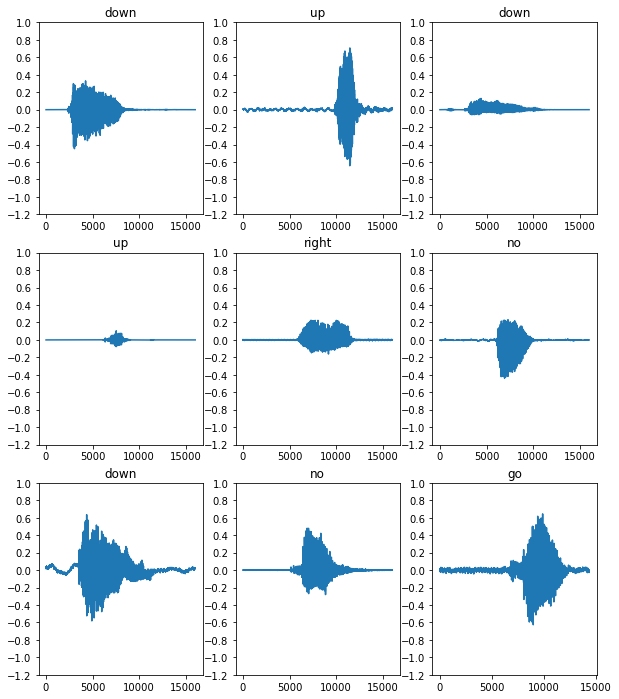

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

In [12]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [13]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Sectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Sectrogram shape: (124, 129, 1)
Audio playback


In [14]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

<ipython-input-14-e14d1abf1aed>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


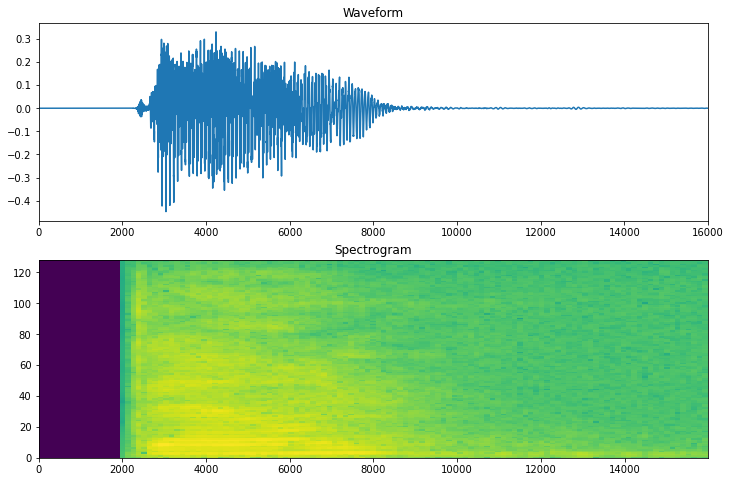

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label==commands)
    return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-14-e14d1abf1aed>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


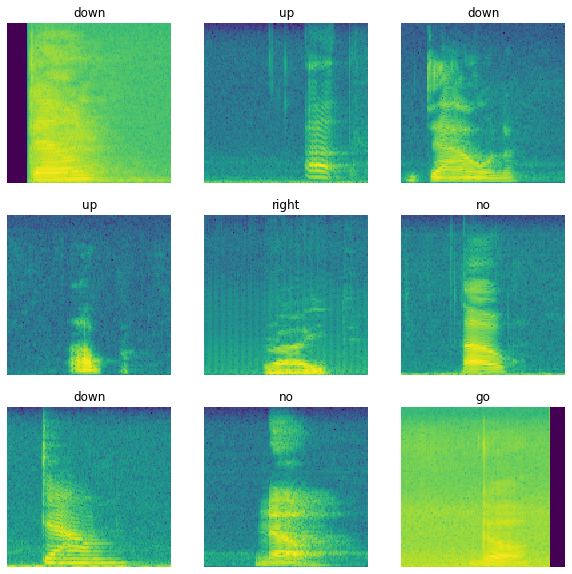

In [19]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')
plt.show()

In [20]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [22]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [24]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels=len(commands)

Input shape: (124, 129, 1)


In [25]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [28]:
EPOCHS = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                                                                                                patience=2))

Epoch 1/10
100/100 [==============================] - 18s 172ms/step - loss: 1.7508 - accuracy: 0.3722 - val_loss: 1.3172 - val_accuracy: 0.5450
Epoch 2/10
100/100 [==============================] - 12s 118ms/step - loss: 1.1901 - accuracy: 0.5844 - val_loss: 0.8966 - val_accuracy: 0.7050
Epoch 3/10
100/100 [==============================] - 12s 120ms/step - loss: 0.9026 - accuracy: 0.6858 - val_loss: 0.7284 - val_accuracy: 0.7437
Epoch 4/10
100/100 [==============================] - 12s 121ms/step - loss: 0.7390 - accuracy: 0.7391 - val_loss: 0.6427 - val_accuracy: 0.7688
Epoch 5/10
100/100 [==============================] - 12s 121ms/step - loss: 0.6411 - accuracy: 0.7686 - val_loss: 0.6133 - val_accuracy: 0.7875
Epoch 6/10
100/100 [==============================] - 12s 119ms/step - loss: 0.5685 - accuracy: 0.8009 - val_loss: 0.5619 - val_accuracy: 0.7900
Epoch 7/10
100/100 [==============================] - 12s 121ms/step - loss: 0.4936 - accuracy: 0.8264 - val_loss: 0.5495 - val_ac

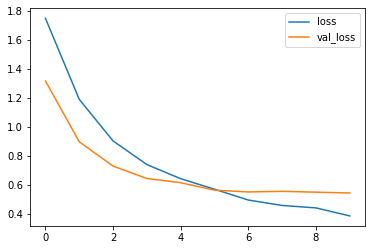

In [29]:
metrics = history.history
plt.plot(history.epoch, metrics["loss"], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [30]:
test_audio = []
test_labels = []
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true)
print(f"Test set accuracy: {test_acc:.0%}")

Test set accuracy: 84%


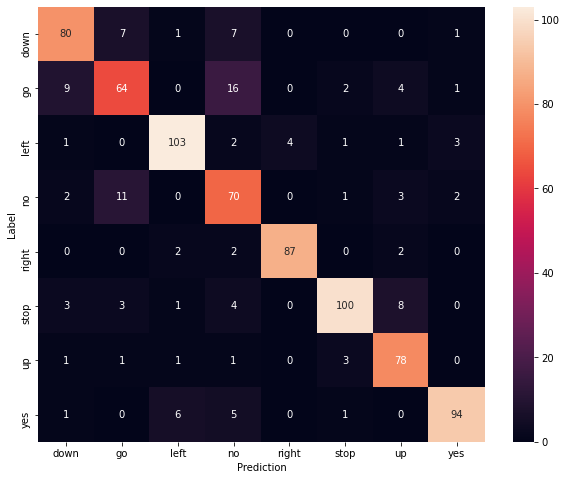

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

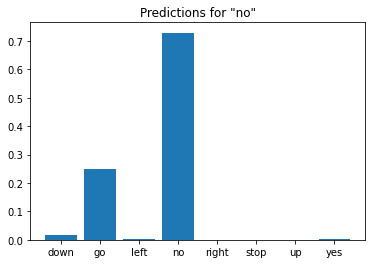

In [33]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])
for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

# Classify structured data using keras preprocessing layers

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.7.0'

In [3]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'
tf.keras.utils.get_file('petfinder_mini.zip', dataset_url, extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [4]:
dataframe.head()

Type  Age                Breed1  Gender Color1    Color2 MaturitySize  \
0  Cat    3                 Tabby    Male  Black     White        Small   
1  Cat    1  Domestic Medium Hair    Male  Black     Brown       Medium   
2  Dog    1           Mixed Breed    Male  Brown     White       Medium   
3  Dog    4           Mixed Breed  Female  Black     Brown       Medium   
4  Dog    1           Mixed Breed    Male  Black  No Color       Medium   

  FurLength Vaccinated Sterilized   Health  Fee  \
0     Short         No         No  Healthy  100   
1    Medium   Not Sure   Not Sure  Healthy    0   
2    Medium        Yes         No  Healthy    0   
3     Short        Yes         No  Healthy  150   
4     Short         No         No  Healthy    0   

                                         Description  PhotoAmt  AdoptionSpeed  
0  Nibble is a 3+ month old ball of cuteness. He ...         1              2  
1  I just found it alone yesterday near my apartm...         2              0  
2  Their pregnant mother was dumped by her irresp...         7              3  
3  Good guard dog, very alert, active, obedience ...         8              2  
4  This handsome yet cute boy is up for adoption....         3              2

In [5]:
dataframe['target'] = np.where(dataframe['AdoptionSpeed'] == 4, 0, 1)
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [6]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [7]:
print(len(train))
print(len(val))
print(len(test))

9229
1154
1154


In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [9]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

<ipython-input-8-1a907ffbf7f9>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print("A batch of ages:", train_features['Age'])
print("A batch of targets:", label_batch)

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[ 3]
 [ 2]
 [ 2]
 [24]
 [11]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([0 1 1 1 0], shape=(5,), dtype=int32)


In [23]:
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [24]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.1466372],
       [-0.508283 ],
       [-0.8274601],
       [-0.508283 ],
       [-0.189106 ]], dtype=float32)>

In [25]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    return lambda feature: encoder(index(feature))

In [14]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type', dataset=train_ds, dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [15]:
test_age_col = train_features["Age"]
test_age_layer = get_category_encoding_layer(name='Age', dataset=train_ds, dtype="int64", max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [16]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-8-1a907ffbf7f9>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [26]:
all_inputs = []
encoded_features = []
for header in ['PhotoAmt', 'Fee']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [27]:
age_col = tf.keras.Input(shape=(1, ), name="Age", dtype='int64')
encoding_layer = get_category_encoding_layer(name='Age', dataset=train_ds, dtype='int64', max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [28]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health'
                   , 'Breed1']
for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1, ), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='string', max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [29]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation='relu')(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

In [31]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

In [33]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 1s 11ms/step - loss: 0.6918 - accuracy: 0.4401 - val_loss: 0.5477 - val_accuracy: 0.7340
Epoch 2/10
37/37 [==============================] - 0s 3ms/step - loss: 0.5952 - accuracy: 0.6448 - val_loss: 0.5172 - val_accuracy: 0.7695
Epoch 3/10
37/37 [==============================] - 0s 3ms/step - loss: 0.5770 - accuracy: 0.6661 - val_loss: 0.5061 - val_accuracy: 0.7669
Epoch 4/10
37/37 [==============================] - 0s 3ms/step - loss: 0.5634 - accuracy: 0.6841 - val_loss: 0.4956 - val_accuracy: 0.7643
Epoch 5/10
37/37 [==============================] - 0s 3ms/step - loss: 0.5555 - accuracy: 0.6922 - val_loss: 0.4894 - val_accuracy: 0.7634
Epoch 6/10
37/37 [==============================] - 0s 3ms/step - loss: 0.5449 - accuracy: 0.7070 - val_loss: 0.4832 - val_accuracy: 0.7652
Epoch 7/10
37/37 [==============================] - 0s 3ms/step - loss: 0.5426 - accuracy: 0.7117 - val_loss: 0.4802 - val_accuracy: 0.7660
Epoch 8/10
37/37 [============

In [34]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 3ms/step - loss: 0.5052 - accuracy: 0.7374
Accuracy 0.737434983253479


In [35]:
model.save("my_pet_classifier")
reloaded_model = tf.keras.models.load_model("my_pet_classifier")

INFO:tensorflow:Assets written to: my_pet_classifier\assets


INFO:tensorflow:Assets written to: my_pet_classifier\assets


In [36]:
sample = {
    'Type':'Cat',
    "Age": 3,
    "Breed1":"Tabby",
    "Gender":'Male',
    'Color1':'Black',
    'Color2':'White',
    'MaturitySize':'Small',
    'FurLength': 'Short',
    'Vaccinated':'No',
    'Sterilized': 'No',
    'Health':'Healthy',
    'Fee':100,
    'PhotoAmt':2
}
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])
print("This particular pet had a %.1f percent probability of getting adopted." %(100*prob))

This particular pet had a 77.8 percent probability of getting adopted.


# Classification on imbalanced data

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import matplotlib as mlp

In [3]:
mlp.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
raw_df = pd.read_csv("datasets_CSV/creditcard.csv")
raw_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [5]:
raw_df.shape

(284807, 31)

In [6]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean  -1.552103e-15  1.701640e-15 -3.662252e-16 -1.217809e-16      88.349619   
std    1.380247e+00  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.137433e+02 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -6.915971e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%   -5.433583e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    6.119264e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    3.480167e+01  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [7]:
neg, pos = np.bincount(raw_df["Class"])
total = neg + pos
print("Examples: \n   Total: {}\n  Positive: {} ({:.2f}% of total)\n".format(total, pos, 100*pos / total))

Examples: 
   Total: 284807
  Positive: 492 (0.17% of total)



In [8]:
cleaned_df = raw_df.copy()
cleaned_df.pop("Time")
eps = 0.001
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop("Amount") + eps)

In [9]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print("Training labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

print("Training features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


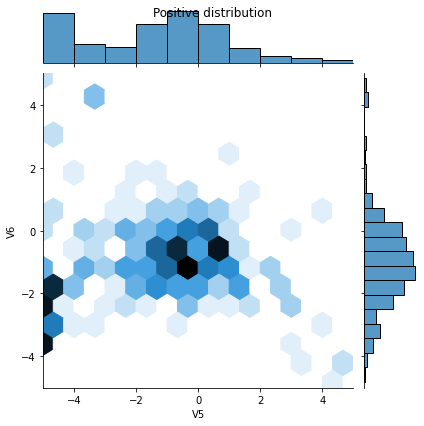

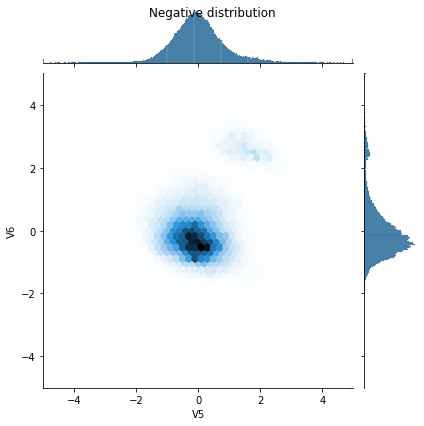

In [11]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5, 5), ylim=(-5, 5))
plt.suptitle("Positive distribution")
sns.jointplot(neg_df['V5'], neg_df['V6'], kind="hex", xlim=(-5, 5), ylim=(-5, 5))
_ = plt.suptitle("Negative distribution")

In [12]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation="relu", input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=metrics)
    return model

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=10, mode='max', 
                                                  restore_best_weights=True)

In [14]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.predict(train_features[:10])

array([[0.5919513 ],
       [0.8528447 ],
       [0.6988015 ],
       [0.5042006 ],
       [0.85416543],
       [0.68855876],
       [0.7391783 ],
       [0.8583994 ],
       [0.71319896],
       [0.67221516]], dtype=float32)

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0562


In [17]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [18]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[6.3261390e-04],
       [5.0151348e-04],
       [2.4992526e-03],
       [6.1932206e-04],
       [2.0828843e-04],
       [7.6606870e-04],
       [1.2669265e-03],
       [9.8904111e-06],
       [9.5793605e-04],
       [6.6399574e-04]], dtype=float32)

In [19]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0160


In [20]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [21]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=20, 
                              validation_data=(val_features, val_labels), verbose=0) 

In [22]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=20, 
                                validation_data=(val_features, val_labels), verbose=0)

In [23]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

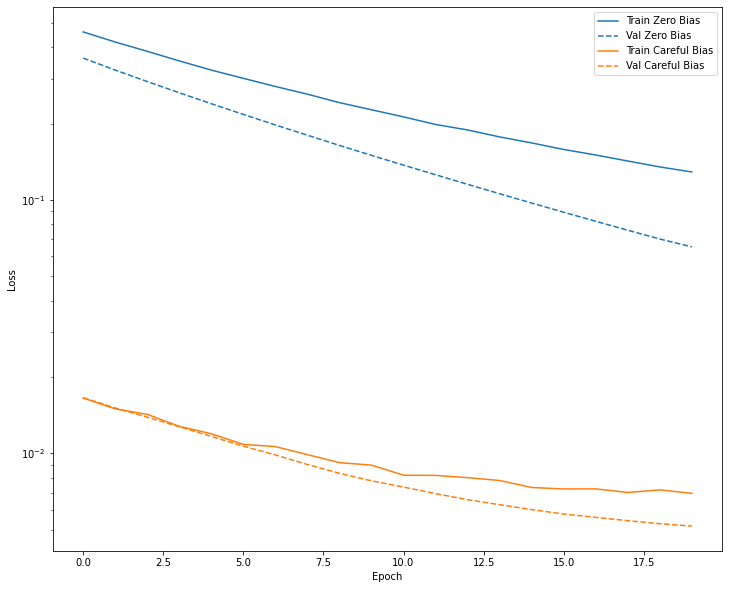

In [24]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [25]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping],
                            validation_data = (val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 5s 23ms/step - loss: 0.0165 - tp: 32.0000 - fp: 58.0000 - tn: 227395.0000 - fn: 360.0000 - accuracy: 0.9982 - precision: 0.3556 - recall: 0.0816 - auc: 0.6272 - prc: 0.0774 - val_loss: 0.0166 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45483.0000 - val_fn: 86.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5194 - val_prc: 0.0033
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0153 - tp: 3.0000 - fp: 47.0000 - tn: 181923.0000 - fn: 303.0000 - accuracy: 0.9981 - precision: 0.0600 - recall: 0.0098 - auc: 0.5655 - prc: 0.0071 - val_loss: 0.0150 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45483.0000 - val_fn: 86.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5546 - val_prc: 0.0096
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0138 - tp: 12.0000 - fp: 39.0000 - tn: 181931.0000 

90/90 [==============================] - 1s 7ms/step - loss: 0.0054 - tp: 149.0000 - fp: 30.0000 - tn: 181940.0000 - fn: 157.0000 - accuracy: 0.9990 - precision: 0.8324 - recall: 0.4869 - auc: 0.8919 - prc: 0.6163 - val_loss: 0.0038 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 45480.0000 - val_fn: 34.0000 - val_accuracy: 0.9992 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.9185 - val_prc: 0.7910
Epoch 40/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0055 - tp: 158.0000 - fp: 27.0000 - tn: 181943.0000 - fn: 148.0000 - accuracy: 0.9990 - precision: 0.8541 - recall: 0.5163 - auc: 0.8822 - prc: 0.6082 - val_loss: 0.0038 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 45480.0000 - val_fn: 34.0000 - val_accuracy: 0.9992 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.9185 - val_prc: 0.7923
Epoch 41/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0057 - tp: 143.0000 - fp: 31.0000 - tn: 181939.0000 - fn: 163.0000 - accuracy: 0.9989 - p

90/90 [==============================] - 1s 10ms/step - loss: 0.0049 - tp: 157.0000 - fp: 31.0000 - tn: 181939.0000 - fn: 149.0000 - accuracy: 0.9990 - precision: 0.8351 - recall: 0.5131 - auc: 0.9088 - prc: 0.6441 - val_loss: 0.0032 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 45480.0000 - val_fn: 26.0000 - val_accuracy: 0.9994 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9416 - val_prc: 0.8380
Epoch 78/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0052 - tp: 158.0000 - fp: 35.0000 - tn: 181935.0000 - fn: 148.0000 - accuracy: 0.9990 - precision: 0.8187 - recall: 0.5163 - auc: 0.8973 - prc: 0.6104 - val_loss: 0.0032 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 45480.0000 - val_fn: 26.0000 - val_accuracy: 0.9994 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9416 - val_prc: 0.8378
Epoch 79/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0047 - tp: 167.0000 - fp: 28.0000 - tn: 181942.0000 - fn: 139.0000 - accuracy: 0.9991 -

In [26]:
def plot_metrics(history):
    metrics = ["loss", "prc", 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Train")
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == "loc":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

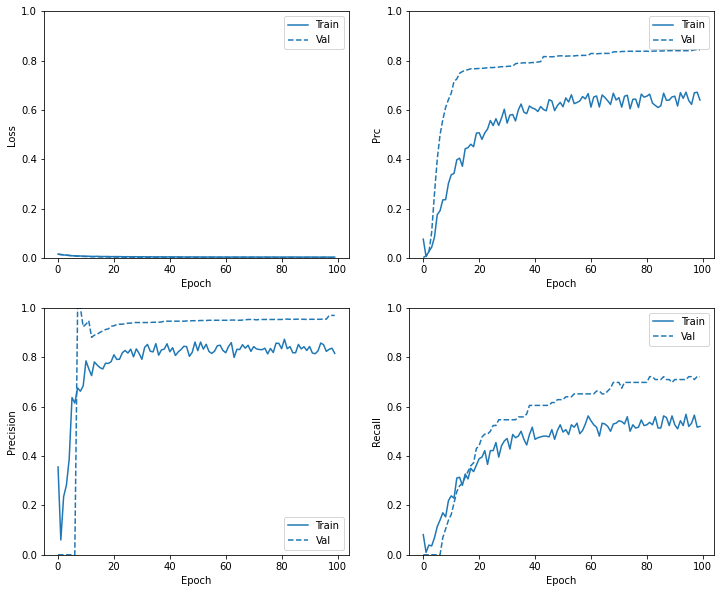

In [27]:
plot_metrics(baseline_history)

In [28]:
train_predicts_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predicts_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [29]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predict label")
    print("Legimate Transactions Detected (True Negatives):", cm[0][0])
    print('Legimate Transactions Incorrect Detected (False Positives):', cm[0][1])
    print("Fraudulent Transactions Missed (False Negatives):", cm[1][0])
    print("Fraudulent Transcation Detected (True Positives):", cm[1][1])
    print('Total Fraudulent Transactions:', np.sum(cm[1]))

loss : 0.0028624646365642548
tp : 70.0
fp : 8.0
tn : 56854.0
fn : 30.0
accuracy : 0.9993329048156738
precision : 0.8974359035491943
recall : 0.699999988079071
auc : 0.949781596660614
prc : 0.8408533930778503

Legimate Transactions Detected (True Negatives): 56854
Legimate Transactions Incorrect Detected (False Positives): 8
Fraudulent Transactions Missed (False Negatives): 30
Fraudulent Transcation Detected (True Positives): 70
Total Fraudulent Transactions: 100


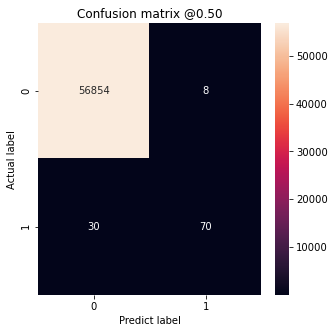

In [30]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ":", value)
print()
plot_cm(test_labels, test_predicts_baseline)

In [31]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False Positives [%]')
    plt.ylabel('Ture Positives [%]')
    plt.xlim([-0.5, 20])
    plt.ylim([80, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

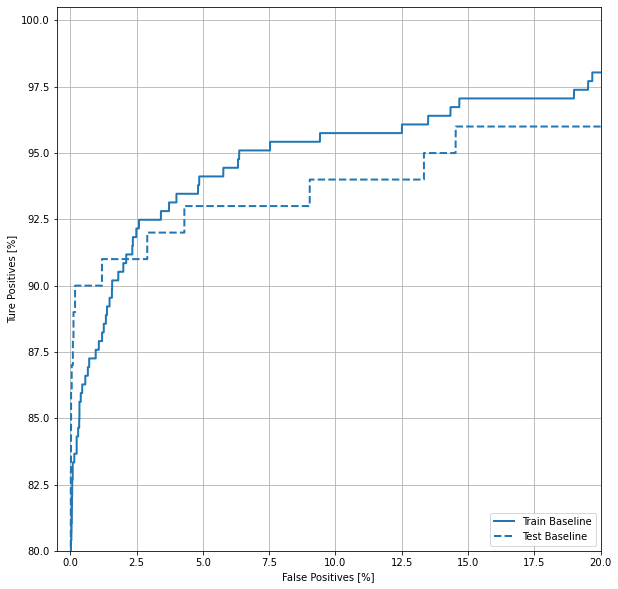

In [32]:
plot_roc("Train Baseline", train_labels, train_predicts_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predicts_baseline, color=colors[0], linestyle="--")
plt.legend(loc="lower right")

In [33]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel("Recall")
    plt.ylabel("Pecision")
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

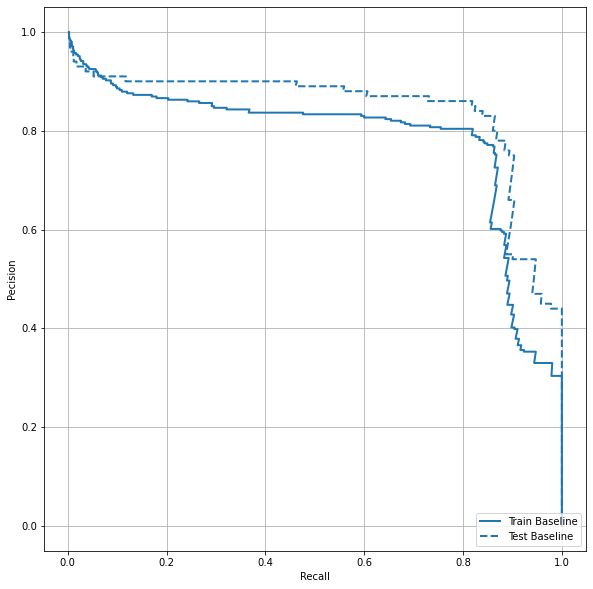

In [34]:
plot_prc("Train Baseline", train_labels, train_predicts_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predicts_baseline, color=colors[0], linestyle='--')
plt.legend(loc="lower right")

In [35]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [36]:
weight_model = make_model()
weight_model.load_weights(initial_weights)
weighted_history = weight_model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                                    callbacks=[early_stopping], validation_data=(val_features, val_labels), 
                                    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 5s 23ms/step - loss: 4.2780 - tp: 75.0000 - fp: 80.0000 - tn: 238752.0000 - fn: 331.0000 - accuracy: 0.9983 - precision: 0.4839 - recall: 0.1847 - auc: 0.6324 - prc: 0.1528 - val_loss: 0.0164 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45483.0000 - val_fn: 86.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5182 - val_prc: 0.0035
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 3.6124 - tp: 4.0000 - fp: 74.0000 - tn: 181896.0000 - fn: 302.0000 - accuracy: 0.9979 - precision: 0.0513 - recall: 0.0131 - auc: 0.6019 - prc: 0.0104 - val_loss: 0.0148 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45483.0000 - val_fn: 86.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5643 - val_prc: 0.0098
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 3.3689 - tp: 9.0000 - fp: 81.0000 - tn: 181889.0000 -

90/90 [==============================] - 1s 8ms/step - loss: 0.7432 - tp: 206.0000 - fp: 600.0000 - tn: 181370.0000 - fn: 100.0000 - accuracy: 0.9962 - precision: 0.2556 - recall: 0.6732 - auc: 0.9081 - prc: 0.4440 - val_loss: 0.0074 - val_tp: 70.0000 - val_fp: 23.0000 - val_tn: 45460.0000 - val_fn: 16.0000 - val_accuracy: 0.9991 - val_precision: 0.7527 - val_recall: 0.8140 - val_auc: 0.9561 - val_prc: 0.7768
Epoch 40/100
90/90 [==============================] - 1s 6ms/step - loss: 0.6732 - tp: 212.0000 - fp: 629.0000 - tn: 181341.0000 - fn: 94.0000 - accuracy: 0.9960 - precision: 0.2521 - recall: 0.6928 - auc: 0.9194 - prc: 0.4189 - val_loss: 0.0075 - val_tp: 70.0000 - val_fp: 26.0000 - val_tn: 45457.0000 - val_fn: 16.0000 - val_accuracy: 0.9991 - val_precision: 0.7292 - val_recall: 0.8140 - val_auc: 0.9558 - val_prc: 0.7793
Epoch 41/100
90/90 [==============================] - 1s 10ms/step - loss: 0.7098 - tp: 218.0000 - fp: 655.0000 - tn: 181315.0000 - fn: 88.0000 - accuracy: 0.9959

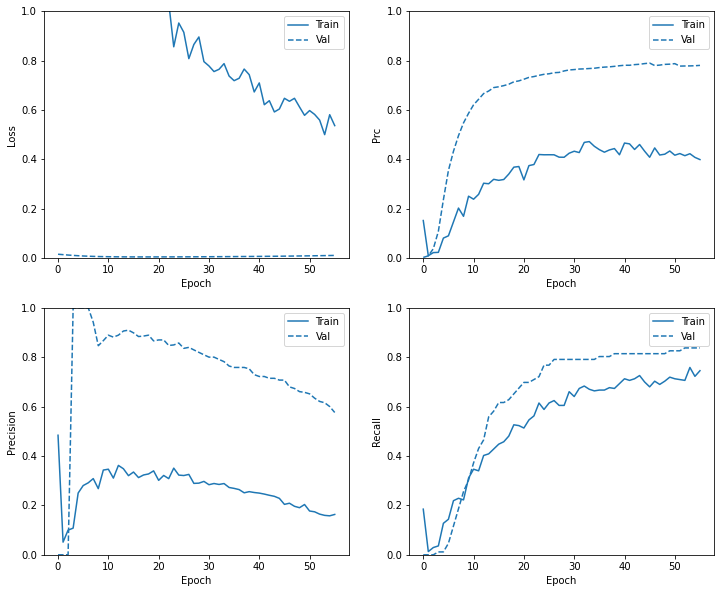

In [37]:
plot_metrics(weighted_history)

In [39]:
train_predictions_weighted = weight_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weight_model.predict(test_features, batch_size=BATCH_SIZE)

loss : 0.010122732259333134
tp : 84.0
fp : 57.0
tn : 56805.0
fn : 16.0
accuracy : 0.9987184405326843
precision : 0.5957446694374084
recall : 0.8399999737739563
auc : 0.959605872631073
prc : 0.7471013069152832

Legimate Transactions Detected (True Negatives): 56805
Legimate Transactions Incorrect Detected (False Positives): 57
Fraudulent Transactions Missed (False Negatives): 16
Fraudulent Transcation Detected (True Positives): 84
Total Fraudulent Transactions: 100


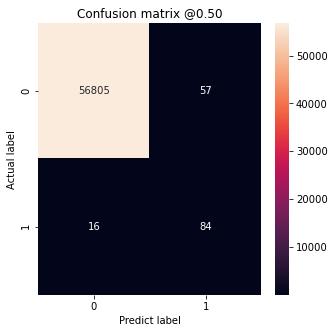

In [42]:
weighted_results = weight_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weight_model.metrics_names, weighted_results):
    print(name, ":", value)
print()
plot_cm(test_labels, test_predictions_weighted)

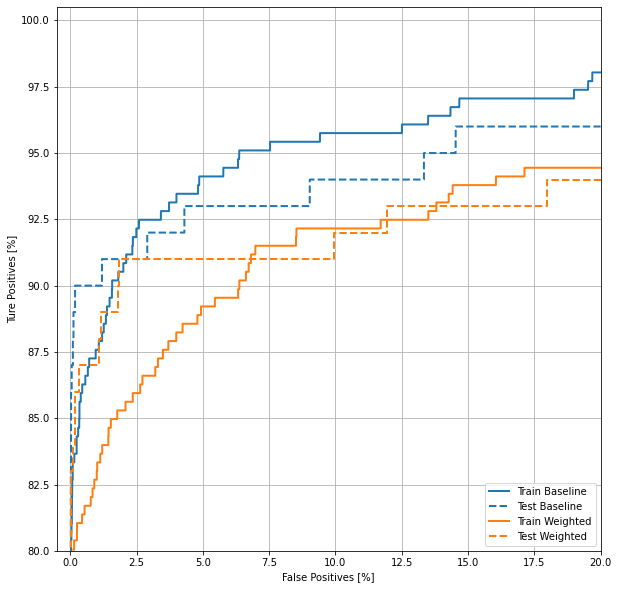

In [45]:
plot_roc("Train Baseline", train_labels, train_predicts_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predicts_baseline, color=colors[0], linestyle="--")
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle="--")
plt.legend(loc="lower right")

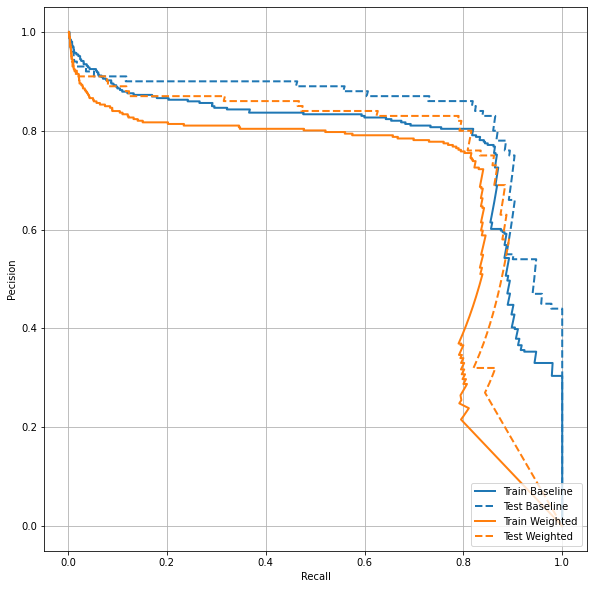

In [46]:
plot_prc("Train Baseline", train_labels, train_predicts_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predicts_baseline, color=colors[0], linestyle="--")
plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle="--")
plt.legend(loc="lower right")

In [47]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]
pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [48]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]
res_pos_features.shape

(181970, 29)

In [49]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_features.shape

(363940, 29)

In [51]:
BUFFER_SIZE = 100000
def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds
pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [52]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-1.64194252  1.62977878 -2.16246804  0.96464206 -1.1978703  -1.3902599
 -2.50883275 -1.500922   -0.19764372 -3.25180475  3.70555062 -5.
 -1.1455932  -5.          1.00814819 -5.         -5.         -3.67896744
  0.1640584   0.74462692  2.46205577 -1.22910531 -0.5127398   0.20169034
 -0.17692233  0.48189175 -0.77812913 -2.22137008  0.57372997]

Label:  1


In [53]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


In [54]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.4990234375


In [55]:
resampled_steps_per_epoch = np.ceil(2.0 * neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [57]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)
resampled_history = resampled_model.fit(resampled_ds, epochs=EPOCHS, steps_per_epoch=resampled_steps_per_epoch, 
                                       callbacks=[early_stopping], validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 14s 39ms/step - loss: 1.1880 - tp: 111048.0000 - fp: 64084.0000 - tn: 278303.0000 - fn: 172871.0000 - accuracy: 0.6217 - precision: 0.6341 - recall: 0.3911 - auc: 0.5823 - prc: 0.6345 - val_loss: 0.4321 - val_tp: 56.0000 - val_fp: 5294.0000 - val_tn: 40189.0000 - val_fn: 30.0000 - val_accuracy: 0.8832 - val_precision: 0.0105 - val_recall: 0.6512 - val_auc: 0.7589 - val_prc: 0.13218.0000 - fp: 12043.0000 - tn: 101317.0000 - fn: 42934.0000 - accuracy: 0.6758 - precision: 0.5249 - recall: 0.2366 - auc: 0.6246 - prc: 0. - ETA: 6s - loss: 1.6424 - tp: 14428.0000 - fp: 12896.0000 - tn: 104588.0000 - fn: 45882.0000 - accuracy: 0.6694 - precision: 0.5280 - recall: 0.2392 - auc: 0. - ETA: 6s - loss: 1.5921 - tp: 19853.0000 - fp: 16868.0000 - tn: 118881.0000 - fn: 59056.0000 - accuracy: 0.6463 - precision: 0.5406 - recall: 0.2516 - auc: 0.5942 - prc:  - ETA: 6s - loss: 1.5737 - tp: 21688.0000 - fp: 18261.0000 - tn: 123758.0000 - fn: 63239.00

278/278 [==============================] - 9s 34ms/step - loss: 0.1689 - tp: 252778.0000 - fp: 11044.0000 - tn: 273312.0000 - fn: 32210.0000 - accuracy: 0.9240 - precision: 0.9581 - recall: 0.8870 - auc: 0.9826 - prc: 0.9847 - val_loss: 0.0938 - val_tp: 77.0000 - val_fp: 877.0000 - val_tn: 44606.0000 - val_fn: 9.0000 - val_accuracy: 0.9806 - val_precision: 0.0807 - val_recall: 0.8953 - val_auc: 0.9857 - val_prc: 0.80200.9235 - prec - ETA: 1s - loss: 0.1695 - tp: 203609.0000 - fp: 8946.0000 - tn: 220171.0000 - fn: 26026.0000 - accuracy: 0.9238 - precision: 0.9579 - recall: 0.8867 - auc: 0.9824 - p - ETA: 1s - loss: 0.1695 - tp: 212683.0000 - fp: 9332.0000 - tn: 230020.0000 - fn: 27197.0000 - accuracy: 0.9238 - precision: 0.9580 - recall: 0.88
Epoch 20/100
278/278 [==============================] - 10s 35ms/step - loss: 0.1628 - tp: 253263.0000 - fp: 10402.0000 - tn: 274094.0000 - fn: 31585.0000 - accuracy: 0.9263 - precision: 0.9605 - recall: 0.8891 - auc: 0.9839 - prc: 0.9858 - val_los

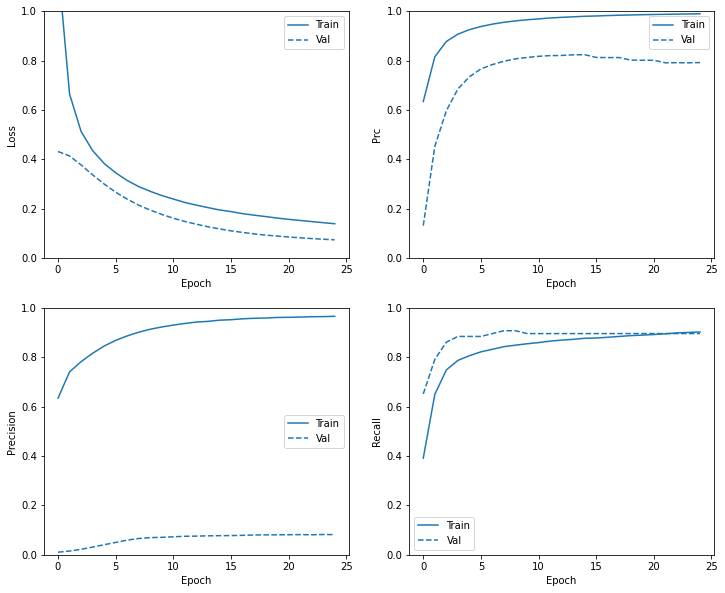

In [58]:
plot_metrics(resampled_history)

In [60]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])
resampled_history = resampled_model.fit(resampled_ds, steps_per_epoch = 20, epochs=10*EPOCHS, callbacks=[early_stopping], 
                                       validation_data=val_ds)

Epoch 1/1000
20/20 [==============================] - 6s 120ms/step - loss: 1.7635 - tp: 4464.0000 - fp: 5074.0000 - tn: 60835.0000 - fn: 16156.0000 - accuracy: 0.7546 - precision: 0.4680 - recall: 0.2165 - auc: 0.5901 - prc: 0.3887 - val_loss: 0.4094 - val_tp: 10.0000 - val_fp: 4773.0000 - val_tn: 40710.0000 - val_fn: 76.0000 - val_accuracy: 0.8936 - val_precision: 0.0021 - val_recall: 0.1163 - val_auc: 0.2505 - val_prc: 0.0021
Epoch 2/1000
20/20 [==============================] - 1s 37ms/step - loss: 1.6317 - tp: 4903.0000 - fp: 4330.0000 - tn: 16059.0000 - fn: 15668.0000 - accuracy: 0.5118 - precision: 0.5310 - recall: 0.2383 - auc: 0.3658 - prc: 0.5153 - val_loss: 0.4128 - val_tp: 13.0000 - val_fp: 4907.0000 - val_tn: 40576.0000 - val_fn: 73.0000 - val_accuracy: 0.8907 - val_precision: 0.0026 - val_recall: 0.1512 - val_auc: 0.2854 - val_prc: 0.0025
Epoch 3/1000
20/20 [==============================] - 1s 57ms/step - loss: 1.5008 - tp: 5486.0000 - fp: 4502.0000 - tn: 16105.0000 - fn

Epoch 20/1000
20/20 [==============================] - 1s 43ms/step - loss: 0.6745 - tp: 13049.0000 - fp: 4927.0000 - tn: 15745.0000 - fn: 7239.0000 - accuracy: 0.7030 - precision: 0.7259 - recall: 0.6432 - auc: 0.7334 - prc: 0.8090 - val_loss: 0.4276 - val_tp: 62.0000 - val_fp: 4987.0000 - val_tn: 40496.0000 - val_fn: 24.0000 - val_accuracy: 0.8900 - val_precision: 0.0123 - val_recall: 0.7209 - val_auc: 0.8363 - val_prc: 0.3205
Epoch 21/1000
20/20 [==============================] - 1s 50ms/step - loss: 0.6591 - tp: 13417.0000 - fp: 4715.0000 - tn: 15669.0000 - fn: 7159.0000 - accuracy: 0.7101 - precision: 0.7400 - recall: 0.6521 - auc: 0.7423 - prc: 0.8173 - val_loss: 0.4263 - val_tp: 62.0000 - val_fp: 4926.0000 - val_tn: 40557.0000 - val_fn: 24.0000 - val_accuracy: 0.8914 - val_precision: 0.0124 - val_recall: 0.7209 - val_auc: 0.8463 - val_prc: 0.3378
Epoch 22/1000
20/20 [==============================] - 1s 48ms/step - loss: 0.6500 - tp: 13691.0000 - fp: 4664.0000 - tn: 15583.0000 -

Epoch 39/1000
20/20 [==============================] - 1s 50ms/step - loss: 0.4901 - tp: 15585.0000 - fp: 4140.0000 - tn: 16290.0000 - fn: 4945.0000 - accuracy: 0.7782 - precision: 0.7901 - recall: 0.7591 - auc: 0.8393 - prc: 0.8864 - val_loss: 0.3854 - val_tp: 74.0000 - val_fp: 3474.0000 - val_tn: 42009.0000 - val_fn: 12.0000 - val_accuracy: 0.9235 - val_precision: 0.0209 - val_recall: 0.8605 - val_auc: 0.9295 - val_prc: 0.57040 - fp: 1911.0000 - tn: 7298.0000 - fn: 2240.0000 - accuracy: 0.7748 - precision: 0.7851 - recall: 0.7571 - auc: 0.8375 - prc:
Epoch 40/1000
20/20 [==============================] - 1s 44ms/step - loss: 0.4819 - tp: 15561.0000 - fp: 4116.0000 - tn: 16445.0000 - fn: 4838.0000 - accuracy: 0.7814 - precision: 0.7908 - recall: 0.7628 - auc: 0.8443 - prc: 0.8892 - val_loss: 0.3827 - val_tp: 74.0000 - val_fp: 3412.0000 - val_tn: 42071.0000 - val_fn: 12.0000 - val_accuracy: 0.9249 - val_precision: 0.0212 - val_recall: 0.8605 - val_auc: 0.9313 - val_prc: 0.5810
Epoch 41

Epoch 76/1000
20/20 [==============================] - 1s 46ms/step - loss: 0.3470 - tp: 16739.0000 - fp: 2593.0000 - tn: 17969.0000 - fn: 3659.0000 - accuracy: 0.8474 - precision: 0.8659 - recall: 0.8206 - auc: 0.9155 - prc: 0.9373 - val_loss: 0.2848 - val_tp: 76.0000 - val_fp: 1597.0000 - val_tn: 43886.0000 - val_fn: 10.0000 - val_accuracy: 0.9647 - val_precision: 0.0454 - val_recall: 0.8837 - val_auc: 0.9670 - val_prc: 0.7520
Epoch 77/1000
20/20 [==============================] - 1s 42ms/step - loss: 0.3420 - tp: 16829.0000 - fp: 2622.0000 - tn: 17924.0000 - fn: 3585.0000 - accuracy: 0.8485 - precision: 0.8652 - recall: 0.8244 - auc: 0.9184 - prc: 0.9395 - val_loss: 0.2823 - val_tp: 76.0000 - val_fp: 1574.0000 - val_tn: 43909.0000 - val_fn: 10.0000 - val_accuracy: 0.9652 - val_precision: 0.0461 - val_recall: 0.8837 - val_auc: 0.9672 - val_prc: 0.7539
Epoch 78/1000
20/20 [==============================] - 1s 50ms/step - loss: 0.3415 - tp: 16829.0000 - fp: 2548.0000 - tn: 17940.0000 -

Epoch 95/1000
20/20 [==============================] - 1s 40ms/step - loss: 0.3063 - tp: 17040.0000 - fp: 2137.0000 - tn: 18411.0000 - fn: 3372.0000 - accuracy: 0.8655 - precision: 0.8886 - recall: 0.8348 - auc: 0.9348 - prc: 0.9502 - val_loss: 0.2438 - val_tp: 77.0000 - val_fp: 1240.0000 - val_tn: 44243.0000 - val_fn: 9.0000 - val_accuracy: 0.9726 - val_precision: 0.0585 - val_recall: 0.8953 - val_auc: 0.9738 - val_prc: 0.7814
Epoch 96/1000
20/20 [==============================] - 1s 51ms/step - loss: 0.3072 - tp: 17109.0000 - fp: 2097.0000 - tn: 18412.0000 - fn: 3342.0000 - accuracy: 0.8672 - precision: 0.8908 - recall: 0.8366 - auc: 0.9338 - prc: 0.9500 - val_loss: 0.2419 - val_tp: 77.0000 - val_fp: 1233.0000 - val_tn: 44250.0000 - val_fn: 9.0000 - val_accuracy: 0.9727 - val_precision: 0.0588 - val_recall: 0.8953 - val_auc: 0.9741 - val_prc: 0.7825
Epoch 97/1000
20/20 [==============================] - 1s 46ms/step - loss: 0.3067 - tp: 17117.0000 - fp: 2079.0000 - tn: 18425.0000 - f

Epoch 114/1000
20/20 [==============================] - 1s 39ms/step - loss: 0.2774 - tp: 17370.0000 - fp: 1737.0000 - tn: 18672.0000 - fn: 3181.0000 - accuracy: 0.8799 - precision: 0.9091 - recall: 0.8452 - auc: 0.9464 - prc: 0.9589 - val_loss: 0.2115 - val_tp: 78.0000 - val_fp: 1099.0000 - val_tn: 44384.0000 - val_fn: 8.0000 - val_accuracy: 0.9757 - val_precision: 0.0663 - val_recall: 0.9070 - val_auc: 0.9786 - val_prc: 0.8000
Epoch 115/1000
20/20 [==============================] - 1s 44ms/step - loss: 0.2762 - tp: 17388.0000 - fp: 1732.0000 - tn: 18646.0000 - fn: 3194.0000 - accuracy: 0.8797 - precision: 0.9094 - recall: 0.8448 - auc: 0.9474 - prc: 0.9595 - val_loss: 0.2100 - val_tp: 78.0000 - val_fp: 1091.0000 - val_tn: 44392.0000 - val_fn: 8.0000 - val_accuracy: 0.9759 - val_precision: 0.0667 - val_recall: 0.9070 - val_auc: 0.9789 - val_prc: 0.8004
Epoch 116/1000
20/20 [==============================] - 1s 54ms/step - loss: 0.2749 - tp: 17343.0000 - fp: 1751.0000 - tn: 18670.0000 

Epoch 133/1000
20/20 [==============================] - 1s 48ms/step - loss: 0.2538 - tp: 17629.0000 - fp: 1502.0000 - tn: 18853.0000 - fn: 2976.0000 - accuracy: 0.8907 - precision: 0.9215 - recall: 0.8556 - auc: 0.9559 - prc: 0.9654 - val_loss: 0.1849 - val_tp: 78.0000 - val_fp: 1028.0000 - val_tn: 44455.0000 - val_fn: 8.0000 - val_accuracy: 0.9773 - val_precision: 0.0705 - val_recall: 0.9070 - val_auc: 0.9819 - val_prc: 0.8106
Epoch 134/1000
20/20 [==============================] - 1s 39ms/step - loss: 0.2553 - tp: 17526.0000 - fp: 1501.0000 - tn: 18946.0000 - fn: 2987.0000 - accuracy: 0.8904 - precision: 0.9211 - recall: 0.8544 - auc: 0.9562 - prc: 0.9651 - val_loss: 0.1836 - val_tp: 78.0000 - val_fp: 1020.0000 - val_tn: 44463.0000 - val_fn: 8.0000 - val_accuracy: 0.9774 - val_precision: 0.0710 - val_recall: 0.9070 - val_auc: 0.9819 - val_prc: 0.8105
Epoch 135/1000
20/20 [==============================] - 1s 53ms/step - loss: 0.2523 - tp: 17869.0000 - fp: 1466.0000 - tn: 18676.0000 

Epoch 152/1000
20/20 [==============================] - 1s 38ms/step - loss: 0.2341 - tp: 17652.0000 - fp: 1304.0000 - tn: 19154.0000 - fn: 2850.0000 - accuracy: 0.8986 - precision: 0.9312 - recall: 0.8610 - auc: 0.9637 - prc: 0.9704 - val_loss: 0.1635 - val_tp: 77.0000 - val_fp: 988.0000 - val_tn: 44495.0000 - val_fn: 9.0000 - val_accuracy: 0.9781 - val_precision: 0.0723 - val_recall: 0.8953 - val_auc: 0.9833 - val_prc: 0.8174
Epoch 153/1000
20/20 [==============================] - 1s 48ms/step - loss: 0.2322 - tp: 17679.0000 - fp: 1240.0000 - tn: 19266.0000 - fn: 2775.0000 - accuracy: 0.9020 - precision: 0.9345 - recall: 0.8643 - auc: 0.9635 - prc: 0.9709 - val_loss: 0.1625 - val_tp: 77.0000 - val_fp: 984.0000 - val_tn: 44499.0000 - val_fn: 9.0000 - val_accuracy: 0.9782 - val_precision: 0.0726 - val_recall: 0.8953 - val_auc: 0.9835 - val_prc: 0.8176
Epoch 154/1000
20/20 [==============================] - 1s 39ms/step - loss: 0.2333 - tp: 17641.0000 - fp: 1267.0000 - tn: 19164.0000 - 

Epoch 171/1000
20/20 [==============================] - 1s 46ms/step - loss: 0.2159 - tp: 17760.0000 - fp: 1101.0000 - tn: 19372.0000 - fn: 2727.0000 - accuracy: 0.9065 - precision: 0.9416 - recall: 0.8669 - auc: 0.9697 - prc: 0.9750 - val_loss: 0.1457 - val_tp: 77.0000 - val_fp: 952.0000 - val_tn: 44531.0000 - val_fn: 9.0000 - val_accuracy: 0.9789 - val_precision: 0.0748 - val_recall: 0.8953 - val_auc: 0.9840 - val_prc: 0.8199
Epoch 172/1000
20/20 [==============================] - 1s 39ms/step - loss: 0.2218 - tp: 17908.0000 - fp: 1201.0000 - tn: 19136.0000 - fn: 2715.0000 - accuracy: 0.9044 - precision: 0.9372 - recall: 0.8684 - auc: 0.9681 - prc: 0.9739 - val_loss: 0.1449 - val_tp: 77.0000 - val_fp: 945.0000 - val_tn: 44538.0000 - val_fn: 9.0000 - val_accuracy: 0.9791 - val_precision: 0.0753 - val_recall: 0.8953 - val_auc: 0.9842 - val_prc: 0.8199
Epoch 173/1000
20/20 [==============================] - 1s 56ms/step - loss: 0.2161 - tp: 17739.0000 - fp: 1126.0000 - tn: 19406.0000 - 

Epoch 190/1000
20/20 [==============================] - 1s 39ms/step - loss: 0.2046 - tp: 17872.0000 - fp: 997.0000 - tn: 19435.0000 - fn: 2656.0000 - accuracy: 0.9108 - precision: 0.9472 - recall: 0.8706 - auc: 0.9732 - prc: 0.9775 - val_loss: 0.1311 - val_tp: 77.0000 - val_fp: 935.0000 - val_tn: 44548.0000 - val_fn: 9.0000 - val_accuracy: 0.9793 - val_precision: 0.0761 - val_recall: 0.8953 - val_auc: 0.9846 - val_prc: 0.8223
Epoch 191/1000
20/20 [==============================] - 1s 41ms/step - loss: 0.2016 - tp: 17901.0000 - fp: 979.0000 - tn: 19478.0000 - fn: 2602.0000 - accuracy: 0.9126 - precision: 0.9481 - recall: 0.8731 - auc: 0.9739 - prc: 0.9783 - val_loss: 0.1304 - val_tp: 77.0000 - val_fp: 935.0000 - val_tn: 44548.0000 - val_fn: 9.0000 - val_accuracy: 0.9793 - val_precision: 0.0761 - val_recall: 0.8953 - val_auc: 0.9845 - val_prc: 0.8223
Epoch 192/1000
20/20 [==============================] - 1s 49ms/step - loss: 0.2021 - tp: 17956.0000 - fp: 1010.0000 - tn: 19439.0000 - fn

Epoch 209/1000
20/20 [==============================] - 1s 49ms/step - loss: 0.1915 - tp: 18021.0000 - fp: 931.0000 - tn: 19501.0000 - fn: 2507.0000 - accuracy: 0.9161 - precision: 0.9509 - recall: 0.8779 - auc: 0.9767 - prc: 0.9804 - val_loss: 0.1191 - val_tp: 77.0000 - val_fp: 928.0000 - val_tn: 44555.0000 - val_fn: 9.0000 - val_accuracy: 0.9794 - val_precision: 0.0766 - val_recall: 0.8953 - val_auc: 0.9849 - val_prc: 0.8243
Epoch 210/1000
20/20 [==============================] - 1s 58ms/step - loss: 0.1893 - tp: 18025.0000 - fp: 912.0000 - tn: 19530.0000 - fn: 2493.0000 - accuracy: 0.9169 - precision: 0.9518 - recall: 0.8785 - auc: 0.9773 - prc: 0.9810 - val_loss: 0.1186 - val_tp: 77.0000 - val_fp: 926.0000 - val_tn: 44557.0000 - val_fn: 9.0000 - val_accuracy: 0.9795 - val_precision: 0.0768 - val_recall: 0.8953 - val_auc: 0.9849 - val_prc: 0.8240
Epoch 211/1000
20/20 [==============================] - 1s 51ms/step - loss: 0.1927 - tp: 18078.0000 - fp: 936.0000 - tn: 19432.0000 - fn:

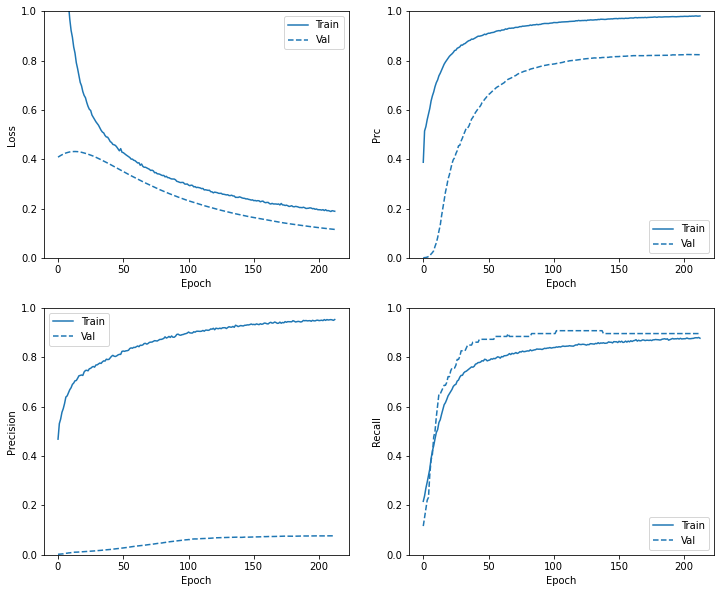

In [61]:
plot_metrics(resampled_history)

In [62]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss : 0.12264175713062286
tp : 90.0
fp : 1060.0
tn : 55802.0
fn : 10.0
accuracy : 0.9812155365943909
precision : 0.0782608687877655
recall : 0.8999999761581421
auc : 0.979174792766571
prc : 0.7765247821807861

Legimate Transactions Detected (True Negatives): 55802
Legimate Transactions Incorrect Detected (False Positives): 1060
Fraudulent Transactions Missed (False Negatives): 10
Fraudulent Transcation Detected (True Positives): 90
Total Fraudulent Transactions: 100


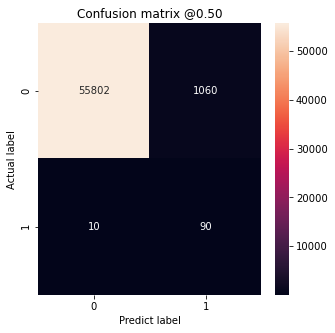

In [63]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ":", value)
print()
plot_cm(test_labels, test_predictions_resampled)

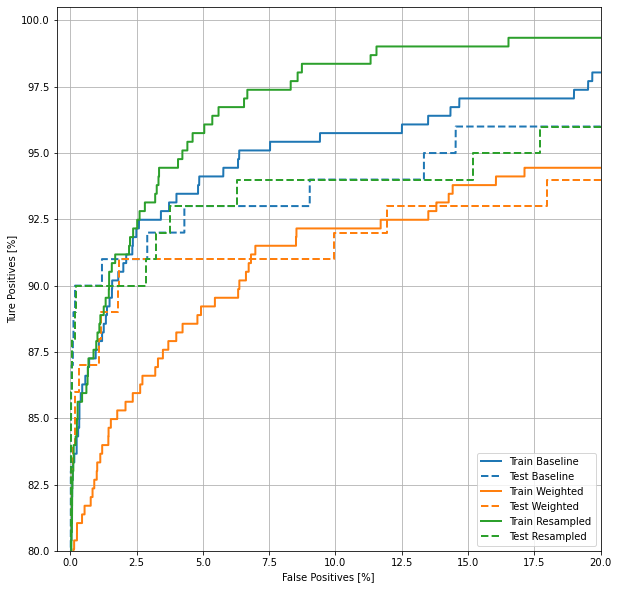

In [65]:
plot_roc("Train Baseline", train_labels, train_predicts_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predicts_baseline, color=colors[0], linestyle="--")
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle="--")
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle="--")
plt.legend(loc="lower right")

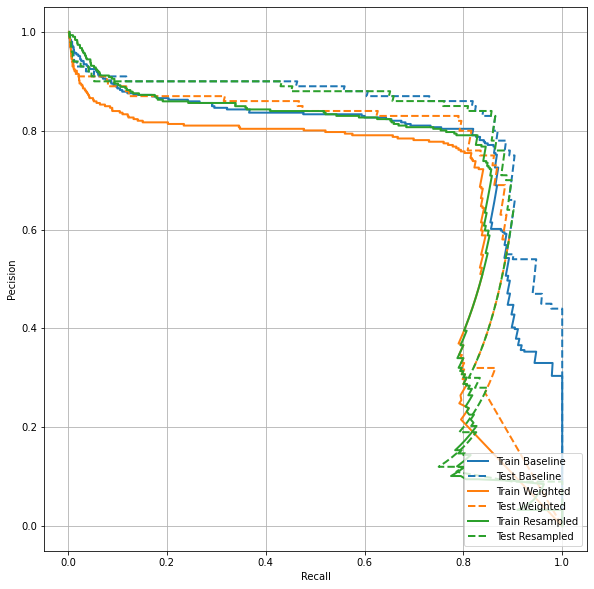

In [66]:
plot_prc("Train Baseline", train_labels, train_predicts_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predicts_baseline, color=colors[0], linestyle="--")
plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle="--")
plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle="--")
plt.legend(loc="lower right")

# Time series forecasting 

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv("datasets_CSV/jena_climate_2009_2016/jena_climate_2009_2016.csv")
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [3]:
df.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
5     996.50     -8.05    265.38        -8.78    94.4          3.33   
11    996.62     -8.88    264.54        -9.77    93.2          3.12   
17    996.84     -8.81    264.59        -9.66    93.5          3.13   
23    996.99     -9.05    264.34       -10.02    92.6          3.07   
29    997.46     -9.63    263.72       -10.65    92.2          2.94   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5           3.14          0.19       1.96             3.15       1307.86   
11          2.90          0.21       1.81             2.91       1312.25   
17          2.93          0.20       1.83             2.94       1312.18   
23          2.85          0.23       1.78             2.85       1313.61   
29          2.71          0.23       1.69             2.71       1317.19   

    wv (m/s)  max. wv (m/s)  wd (deg)  
5       0.21           0.63     192.7  
11      0.25           0.63     190.3  
17      0.18           0.63     167.2  
23      0.10           0.38     240.0  
29      0.40           0.88     157.0

In [4]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features

T (degC)  p (mbar)  rho (g/m**3)
5          -8.05    996.50       1307.86
11         -8.88    996.62       1312.25
17         -8.81    996.84       1312.18
23         -9.05    996.99       1313.61
29         -9.63    997.46       1317.19
...          ...       ...           ...
420521     -0.98   1002.18       1280.70
420527     -1.40   1001.40       1281.87
420533     -2.75   1001.19       1288.02
420539     -2.89   1000.65       1288.03
420545     -3.93   1000.11       1292.41

[70091 rows x 3 columns]

In [5]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [6]:
plot_features.index=date_time

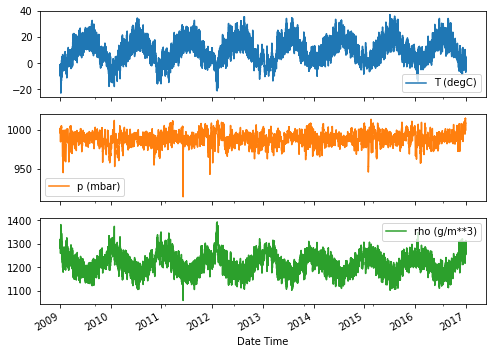

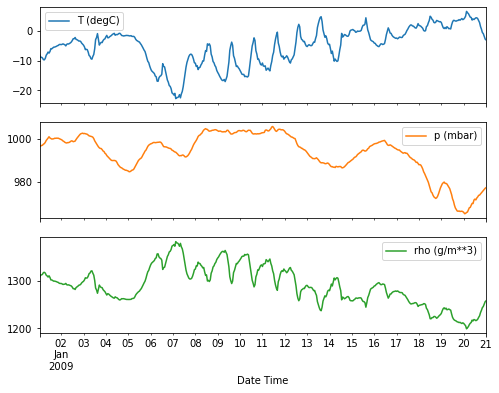

In [7]:
_ = plot_features.plot(subplots=True)
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
df.describe().transpose()

count         mean        std      min      25%      50%  \
p (mbar)         70091.0   989.212842   8.358886   913.60   984.20   989.57   
T (degC)         70091.0     9.450482   8.423384   -22.76     3.35     9.41   
Tpot (K)         70091.0   283.493086   8.504424   250.85   277.44   283.46   
Tdew (degC)      70091.0     4.956471   6.730081   -24.80     0.24     5.21   
rh (%)           70091.0    76.009788  16.474920    13.88    65.21    79.30   
VPmax (mbar)     70091.0    13.576576   7.739883     0.97     7.77    11.82   
VPact (mbar)     70091.0     9.533968   4.183658     0.81     6.22     8.86   
VPdef (mbar)     70091.0     4.042536   4.898549     0.00     0.87     2.19   
sh (g/kg)        70091.0     6.022560   2.655812     0.51     3.92     5.59   
H2OC (mmol/mol)  70091.0     9.640437   4.234862     0.81     6.29     8.96   
rho (g/m**3)     70091.0  1216.061232  39.974263  1059.45  1187.47  1213.80   
wv (m/s)         70091.0     1.702567  65.447512 -9999.00     0.99     1.76   
max. wv (m/s)    70091.0     2.963041  75.597657 -9999.00     1.76     2.98   
wd (deg)         70091.0   174.789095  86.619431     0.00   125.30   198.10   

                      75%      max  
p (mbar)          994.720  1015.29  
T (degC)           15.480    37.28  
Tpot (K)          289.530   311.21  
Tdew (degC)        10.080    23.06  
rh (%)             89.400   100.00  
VPmax (mbar)       17.610    63.77  
VPact (mbar)       12.360    28.25  
VPdef (mbar)        5.300    46.01  
sh (g/kg)           7.800    18.07  
H2OC (mmol/mol)    12.490    28.74  
rho (g/m**3)     1242.765  1393.54  
wv (m/s)            2.860    14.01  
max. wv (m/s)       4.740    23.50  
wd (deg)          234.000   360.00

In [9]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.00
max_wv[bad_max_wv] = 0.0
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

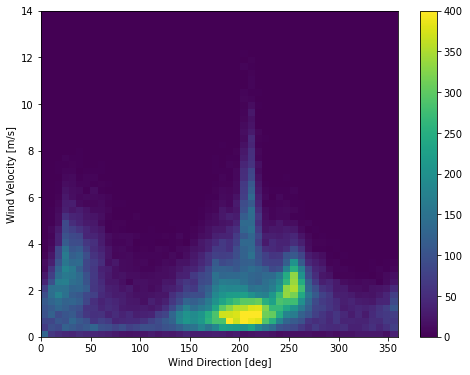

In [10]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [11]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)') * np.pi / 180
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

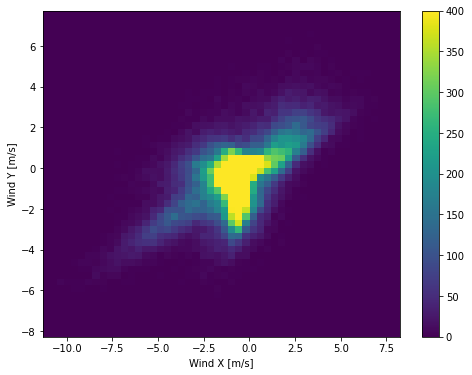

In [12]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [13]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

In [14]:
day = 24*60*60
year = (365.2425) * day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of the signal')

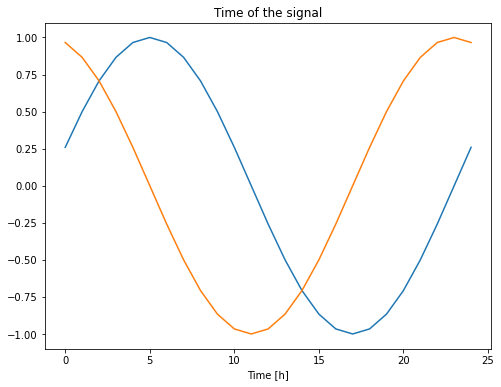

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of the signal')

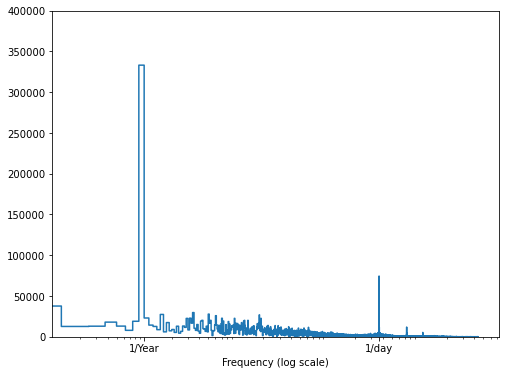

In [16]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

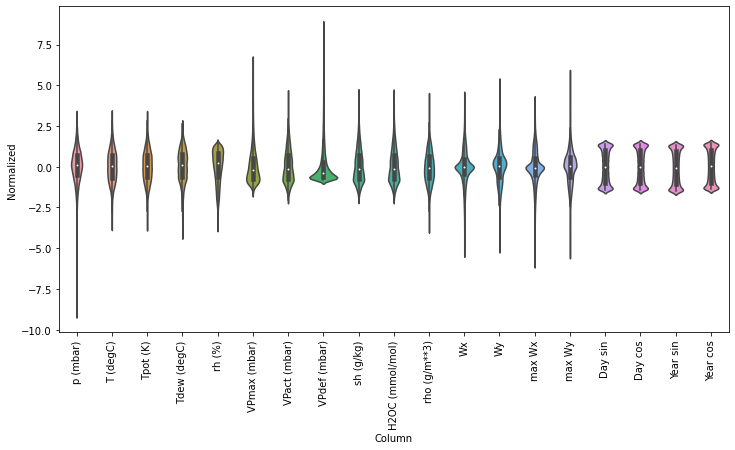

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [20]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    def __repr__(self):
        return '\n'.join([f'Total window size: {self.total_window_size}', 
                         f'Input indices: {self.input_indices}', 
                         f'Label indices: {self.label_indices}',
                         f'Label column name(s): {self.label_columns}'])

In [21]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])

In [22]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [23]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])

In [24]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [25]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
WindowGenerator.split_window = split_window

In [26]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                          np.array(train_df[100:100+w2.total_window_size]),
                          np.array(train_df[200:200+w2.total_window_size])])
example_inputs, example_labels = w2.split_window(example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [27]:
w2.example = example_inputs, example_labels

In [28]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        if label_col_index is None:
            continue
        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', 
                        label='Predictions', c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')
WindowGenerator.plot = plot

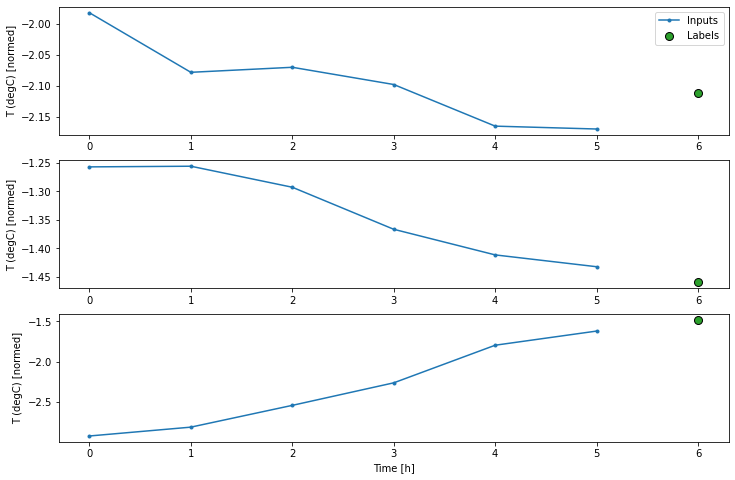

In [29]:
w2.plot()

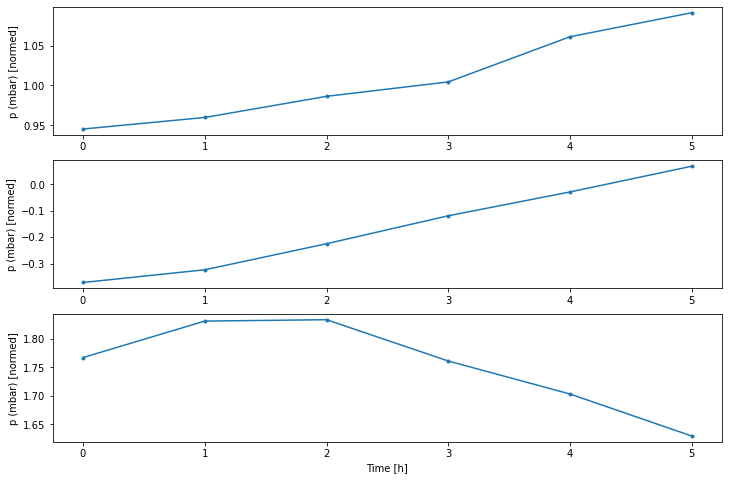

In [30]:
w2.plot(plot_col='p (mbar)')

In [31]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None, 
                                                              sequence_length=self.total_window_size, sequence_stride=1, 
                                                             shuffle=True, batch_size=32)
    ds = ds.map(self.split_window)
    return ds
WindowGenerator.make_dataset = make_dataset

In [32]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [33]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [34]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [35]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [36]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [37]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [38]:
baseline = Baseline(label_index=column_indices['T (degC)'])
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [39]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['T (degC)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [40]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


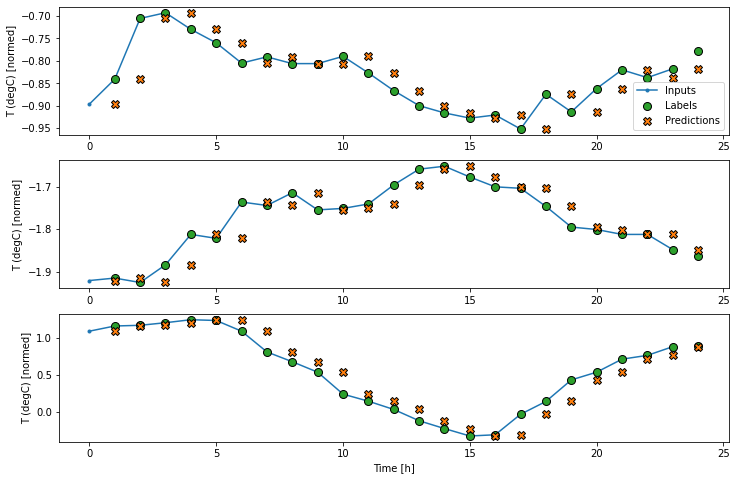

In [41]:
wide_window.plot(baseline)

In [42]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [43]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [44]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), 
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    return history

In [45]:
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 6s 3ms/step - loss: 0.2215 - mean_absolute_error: 0.3088 - val_loss: 0.0275 - val_mean_absolute_error: 0.1244
Epoch 2/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.0998 - val_loss: 0.0115 - val_mean_absolute_error: 0.0792
Epoch 3/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0113 - mean_absolute_error: 0.0787 - val_loss: 0.0104 - val_mean_absolute_error: 0.0757
Epoch 4/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0105 - mean_absolute_error: 0.0759 - val_loss: 0.0102 - val_mean_absolute_error: 0.0758
Epoch 5/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0101 - mean_absolute_error: 0.0741 - val_loss: 0.0098 - val_mean_absolute_error: 0.0738
Epoch 6/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0098 - mean_absolute_error: 0.0729 - val_loss: 0.0096 - val_mean_absolute_error: 0.0730
Epoc

In [46]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


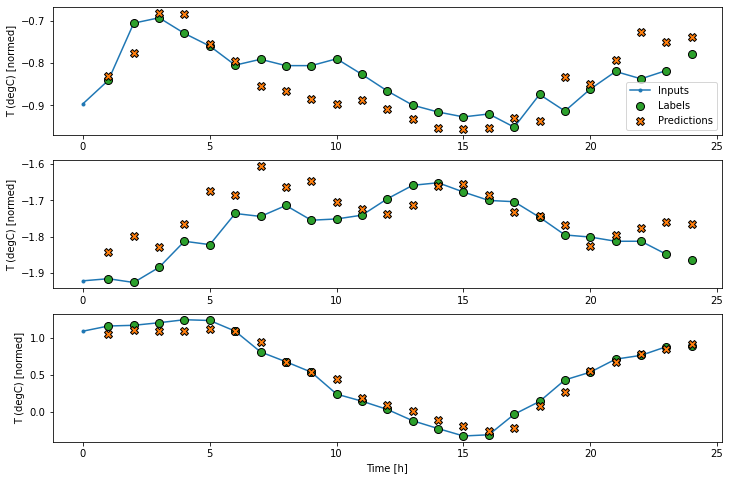

In [47]:
wide_window.plot(linear)

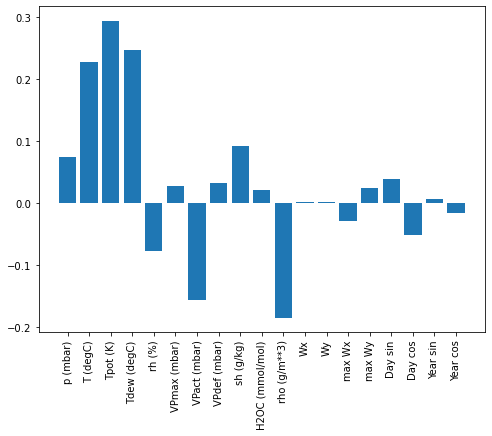

In [48]:
plt.bar(x = range(len(train_df.columns)), height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [49]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 8s 4ms/step - loss: 0.0169 - mean_absolute_error: 0.0807 - val_loss: 0.0086 - val_mean_absolute_error: 0.0690
Epoch 2/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0078 - mean_absolute_error: 0.0640 - val_loss: 0.0073 - val_mean_absolute_error: 0.0612
Epoch 3/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0621 - val_loss: 0.0067 - val_mean_absolute_error: 0.0582
Epoch 4/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0603 - val_loss: 0.0066 - val_mean_absolute_error: 0.0577
Epoch 5/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0596 - val_loss: 0.0069 - val_mean_absolute_error: 0.0579
Epoch 6/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0587 - val_loss: 0.0066 - val_mean_absolute_error: 0.0574
Epoc

In [50]:
CONV_WIDTH = 3
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=['T (degC)'])
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future')

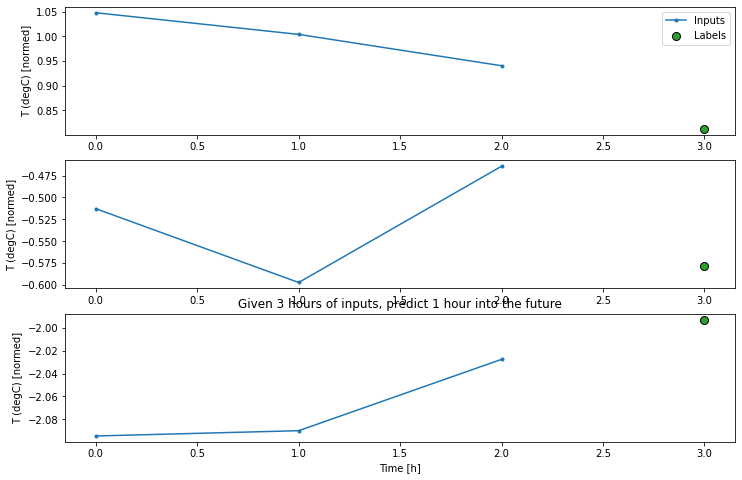

In [51]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future")

In [52]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

In [53]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [54]:
history = compile_and_fit(multi_step_dense, conv_window)
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0082 - mean_absolute_error: 0.0661


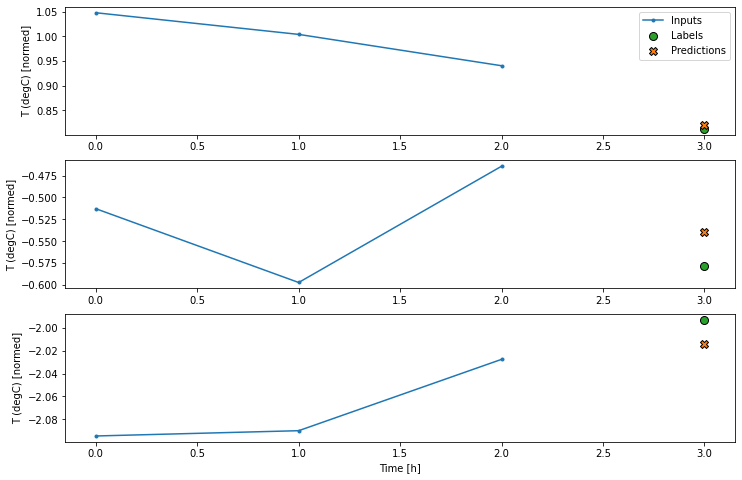

In [55]:
conv_window.plot(multi_step_dense)

In [57]:
print('Input shape: ', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape:  (32, 24, 19)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1of input shape to have value 57, but received input with shape (32, 456)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


In [58]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH, ), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [59]:
print("Conv model on `conv_window`")
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [60]:
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0064 - mean_absolute_error: 0.0566


In [61]:
print("Wide window")
print("Input shape:", wide_window.example[0].shape)
print("Labels shape:", wide_window.example[1].shape)
print("Output shape:", conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [62]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['T (degC)'])
wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [63]:
print("Wide conv window")
print("Input shape:", wide_conv_window.example[0].shape)
print("Labels shape:", wide_conv_window.example[1].shape)
print("Output shape:", conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


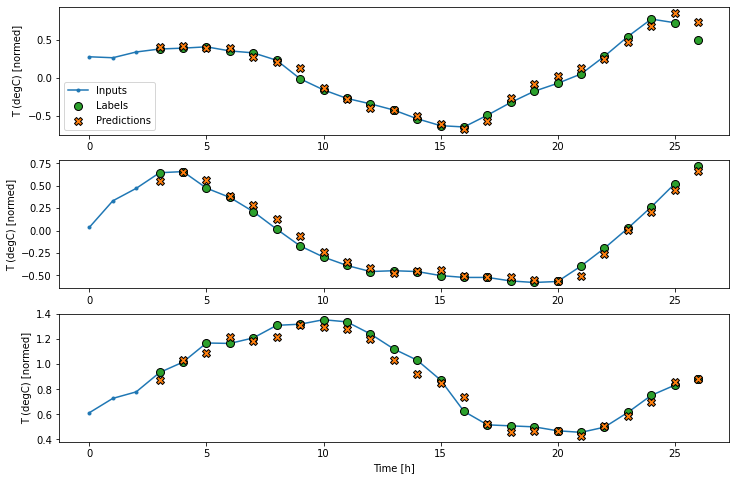

In [64]:
wide_conv_window.plot(conv_model)

In [65]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [67]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [68]:
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0511


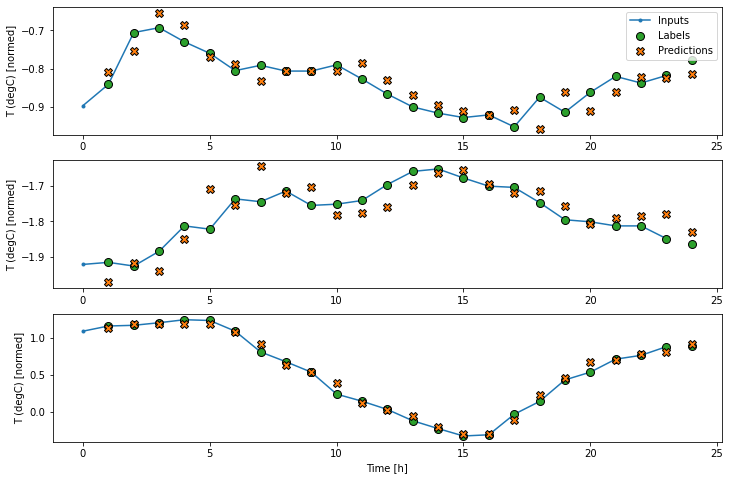

In [69]:
wide_window.plot(lstm_model)

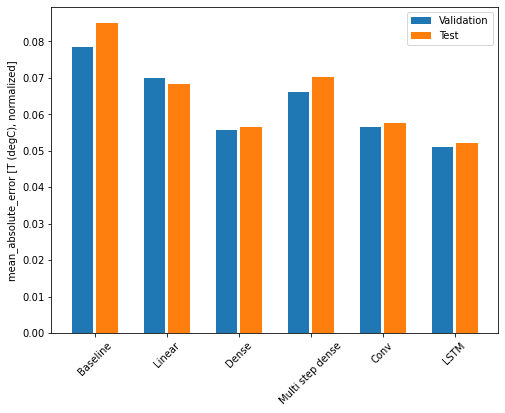

In [71]:
x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [72]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0684
Dense       : 0.0565
Multi step dense: 0.0701
Conv        : 0.0576
LSTM        : 0.0521


In [75]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1)
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)
for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


In [77]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

In [78]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


In [79]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [80]:
history = compile_and_fit(dense, single_step_window)
IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0682 - mean_absolute_error: 0.1298


In [81]:
%%time 
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=num_features)
])
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 1s 3ms/step - loss: 0.0616 - mean_absolute_error: 0.1203

Wall time: 2min 59s


In [82]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        return inputs + delta

In [83]:
%%time 
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(num_features, kernel_initializer=tf.initializers.zeros())
    ])
)
history = compile_and_fit(residual_lstm, wide_window)
IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 3s 7ms/step - loss: 0.0622 - mean_absolute_error: 0.1184

Wall time: 1min 43s


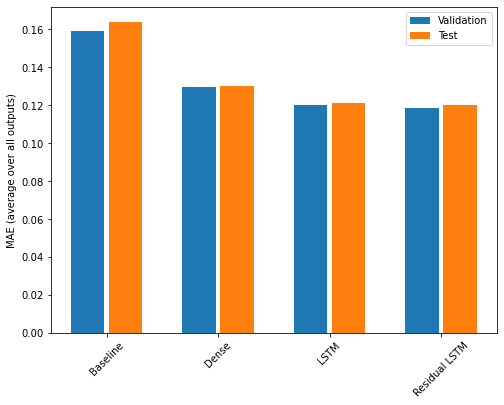

In [85]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [86]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1304
LSTM           : 0.1211
Residual LSTM  : 0.1199


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

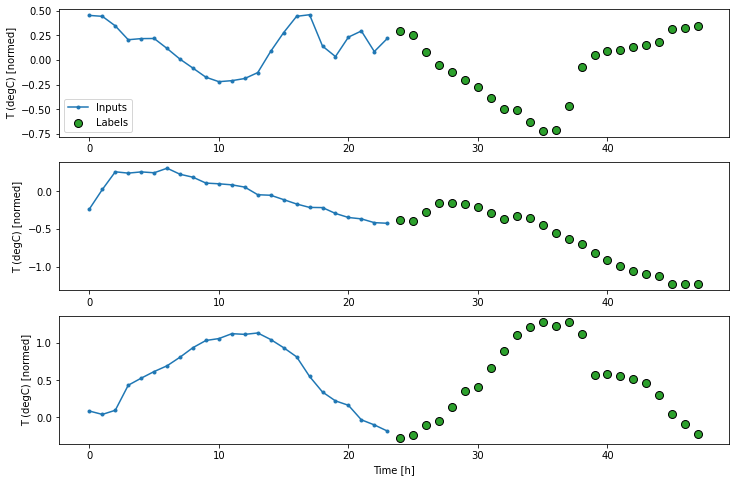

In [87]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
multi_window.plot()
multi_window

437/437 [==============================] - 1s 3ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


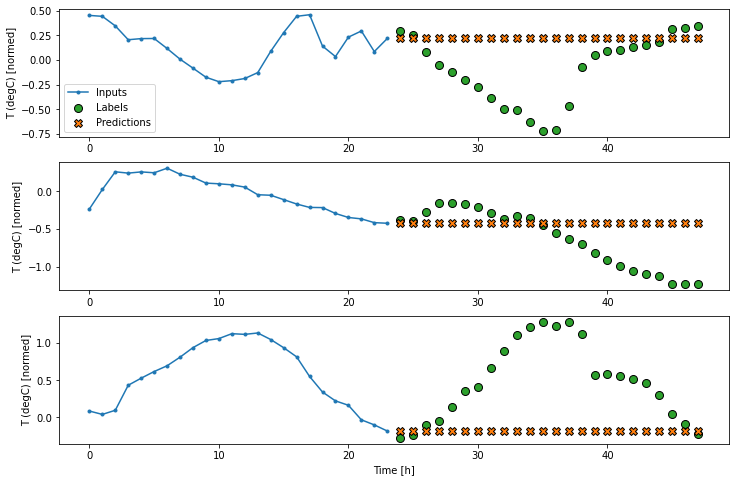

In [88]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])
multi_val_performance = {}
multi_performance = {}
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

437/437 [==============================] - 1s 3ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


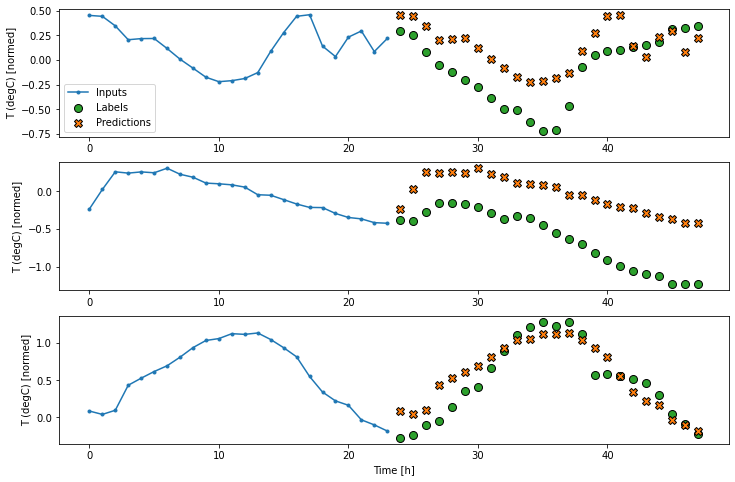

In [90]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

437/437 [==============================] - 1s 3ms/step - loss: 0.2560 - mean_absolute_error: 0.3053


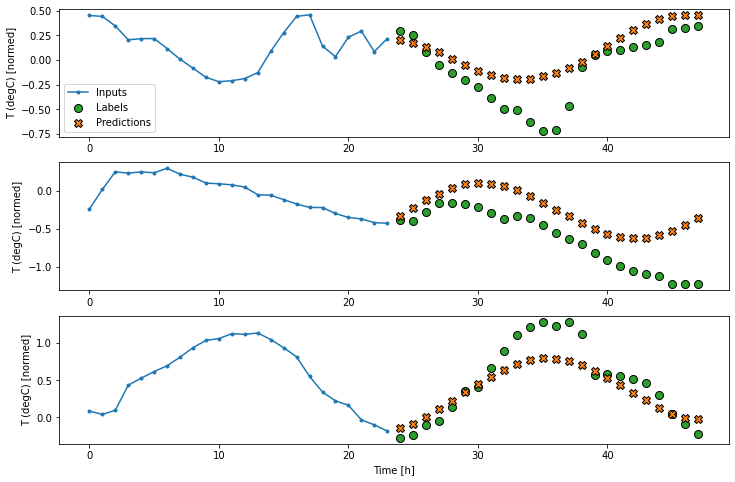

In [91]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

437/437 [==============================] - 2s 5ms/step - loss: 0.2216 - mean_absolute_error: 0.2848


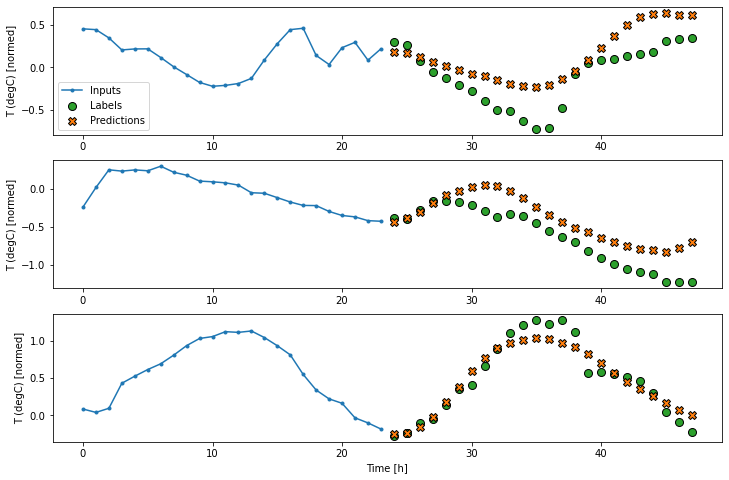

In [94]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_dense_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

437/437 [==============================] - 2s 3ms/step - loss: 0.2171 - mean_absolute_error: 0.2844


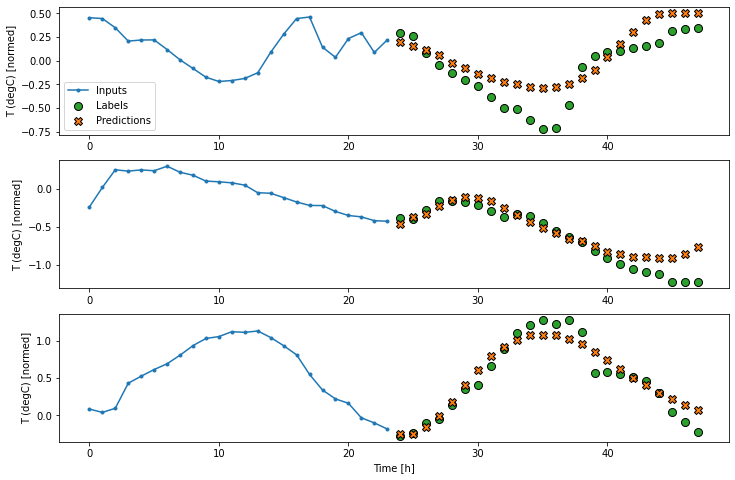

In [95]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_conv_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

437/437 [==============================] - 3s 6ms/step - loss: 0.2137 - mean_absolute_error: 0.2840


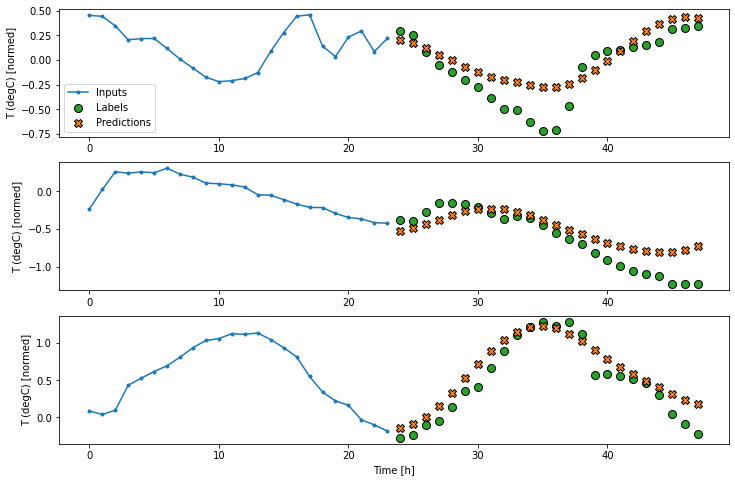

In [97]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_lstm_model, multi_window)
IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [100]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [101]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [105]:
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    predictions = self.dense(x)
    return predictions, state
FeedBack.warmup = warmup

In [106]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

In [107]:
def call(self, inputs, training=None):
    predictions = []
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)
    for n in range(1, self.out_steps):
        x = prediction
        x, state = self.lstm_cell(x, states=state, training=training)
        prediction = self.dense(x)
        predictions.append(prediction)
    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions
FeedBack.call = call

In [131]:
print('Outpu shape (batch, time, features):', feedback_model(multi_window.example[0]).shape)

Outpu shape (batch, time, features): (32, 24, 19)


437/437 [==============================] - 4s 9ms/step - loss: 0.2304 - mean_absolute_error: 0.3047


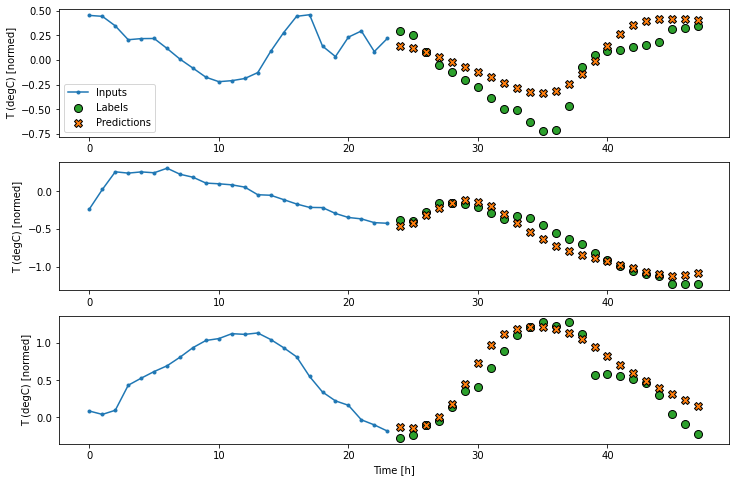

In [132]:
history = compile_and_fit(feedback_model, multi_window)
IPython.display.clear_output()
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

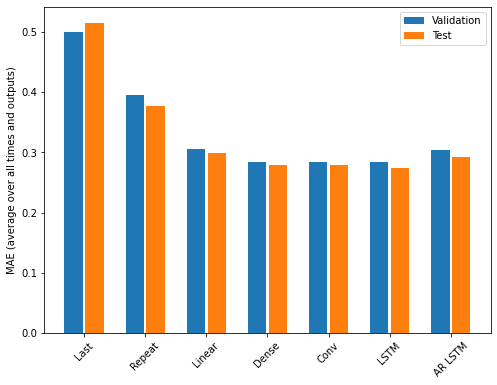

In [135]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [136]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:-.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2984
Dense   : 0.2796
Conv    : 0.2798
LSTM    : 0.2747
AR LSTM : 0.2921


# Recommenders

In [1]:
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [2]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")
ratings = ratings.map(lambda x: {"movie_title": x["movie_title"], "user_id": x["user_id"]})
movies = movies.map(lambda x: x["movie_title"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to C:\Users\jatin\tensorflow_datasets\movielens\100k-ratings\0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to C:\Users\jatin\tensorflow_datasets\movielens\100k-movies\0.1.0. Subsequent calls will reuse this data.


In [3]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

In [4]:
class MovieLensModel(tfrs.Model):
    def __init__(self, user_model: tf.keras.Model, movie_model:tf.keras.Model, task:tfrs.tasks.Retrieval):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False)->tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

In [6]:
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(movies.batch(128).map(movie_model)))

In [7]:
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))
model.fit(ratings.batch(4096), epochs=3)
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(movies.batch(100).map(lambda title: (title, model.movie_model(title))))
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")

Epoch 1/3
25/25 [==============================] - 21s 732ms/step - factorized_top_k/top_1_categorical_accuracy: 9.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0049 - factorized_top_k/top_50_categorical_accuracy: 0.0459 - factorized_top_k/top_100_categorical_accuracy: 0.1038 - loss: 33085.2803 - regularization_loss: 0.0000e+00 - total_loss: 33085.2803
Epoch 2/3
25/25 [==============================] - 18s 727ms/step - factorized_top_k/top_1_categorical_accuracy: 2.9000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0052 - factorized_top_k/top_10_categorical_accuracy: 0.0145 - factorized_top_k/top_50_categorical_accuracy: 0.1046 - factorized_top_k/top_100_categorical_accuracy: 0.2117 - loss: 31014.1864 - regularization_loss: 0.0000e+00 - total_loss: 31014.1864
Epoch 3/3
25/25 [==============================] - 18s 724ms/step - factorized_top_k/top_1_categorical_accuracy: 7.5000e-04 - factorized_top_k/top_5_categor

# Recommenders movies retrieval

In [2]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [3]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

In [4]:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7], dtype=int64),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [5]:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': array([4], dtype=int64),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


In [6]:
ratings = ratings.map(lambda x: {"movie_title":x["movie_title"], "user_id":x["user_id"]})
movies = movies.map(lambda x: x["movie_title"])

In [7]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [9]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

In [10]:
embedding_dimension = 32

In [12]:
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

In [13]:
movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

In [14]:
metrics = tfrs.metrics.FactorizedTopK(candidates=movies.batch(128).map(movie_model))

In [16]:
task = tfrs.tasks.Retrieval(metrics=metrics)

In [26]:
class MovielensModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False)->tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

In [27]:
class NoBaseClassMovielensModel(tf.keras.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.Layer = task
    def train_step(self, features: Dict[Text, tf.Tensor])->tf.Tensor:
        with tf.GradientTape() as tape:
            user_embeddings = self.user_model(features["user_id"])
            positive_movie_embeddings = self.movie_model(features["movie_title"])
            loss = self.task(user_embeddings, positive_movie_embeddings)
            regularization_loss = sum(self.losses)
            total_loss = loss + regularization_loss
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss
        return metrics
    def test_step(self, feature: Dict[Text, tf.Tensor])->tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_titles"])
        loss = self.task(user_embeddings, positive_movie_embeddings)
        regularization_loss = sum(self.losses)
        total_loss = loss + regularization_loss
        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss
        return metrics

In [28]:
model = MovielensModel(user_model = user_model, movie_model = movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [29]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [30]:
model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 20s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0096 - factorized_top_k/top_10_categorical_accuracy: 0.0208 - factorized_top_k/top_50_categorical_accuracy: 0.1028 - factorized_top_k/top_100_categorical_accuracy: 0.1817 - loss: 69858.7209 - regularization_loss: 0.0000e+00 - total_loss: 69858.7209
Epoch 2/3
10/10 [==============================] - 16s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0197 - factorized_top_k/top_10_categorical_accuracy: 0.0405 - factorized_top_k/top_50_categorical_accuracy: 0.1746 - factorized_top_k/top_100_categorical_accuracy: 0.3002 - loss: 67464.2415 - regularization_loss: 0.0000e+00 - total_loss: 67464.2415
Epoch 3/3
10/10 [==============================] - 16s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0033 - factorized_top_k/top_5_categorical_accuracy: 0.0233

In [31]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 5s 654ms/step - factorized_top_k/top_1_categorical_accuracy: 7.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0088 - factorized_top_k/top_10_categorical_accuracy: 0.0212 - factorized_top_k/top_50_categorical_accuracy: 0.1222 - factorized_top_k/top_100_categorical_accuracy: 0.2356 - loss: 31087.4782 - regularization_loss: 0.0000e+00 - total_loss: 31087.4782


{'factorized_top_k/top_1_categorical_accuracy': 0.000750000006519258,
 'factorized_top_k/top_5_categorical_accuracy': 0.008799999952316284,
 'factorized_top_k/top_10_categorical_accuracy': 0.021199999377131462,
 'factorized_top_k/top_50_categorical_accuracy': 0.12219999730587006,
 'factorized_top_k/top_100_categorical_accuracy': 0.23559999465942383,
 'loss': 28240.84765625,
 'regularization_loss': 0,
 'total_loss': 28240.84765625}

In [32]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model))))
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'Bridges of Madison County, The (1995)' b'Aristocats, The (1970)'
 b'Rudy (1993)']


In [33]:
with tempfile.TemporaryDirectory() as tmp:
    path = os.path.join(tmp, "model")
    tf.saved_model.save(index, path)
    loaded = tf.saved_model.load(path)
    sources, titles = loaded(["42"])
    print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: C:\Users\jatin\AppData\Local\Temp\tmpz6qsx8fa\model\assets


INFO:tensorflow:Assets written to: C:\Users\jatin\AppData\Local\Temp\tmpz6qsx8fa\model\assets


Recommendations: [b'Bridges of Madison County, The (1995)' b'Aristocats, The (1970)'
 b'Rudy (1993)']


# Recommending movies ranking

In [12]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [13]:
ratings = tfds.load("movielens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {"movie_title": x["movie_title"], "user_id":x["user_id"], "user_rating":x["user_rating"]})

In [14]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [18]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [19]:
class RankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        
        self.movie_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        
        self.ratings = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
    def call(self, inputs):
        user_id, movie_title = inputs
        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_title)
        return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [20]:
RankingModel()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03740937]], dtype=float32)>

In [21]:
task = tfrs.tasks.Ranking(loss = tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [22]:
class MovielensModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanSquaredError(),
                                                                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    def call(self, features: Dict[str, tf.Tensor])->tf.Tensor:
        return self.ranking_model((features["user_id"], features["movie_title"]))
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False)->tf.Tensor:
        labels = features.pop("user_rating")
        rating_predictions = self(features)
        return self.task(labels=labels, predictions=rating_predictions)

In [23]:
model = MovielensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [24]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [25]:
model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 3s 74ms/step - root_mean_squared_error: 2.1718 - loss: 4.3303 - regularization_loss: 0.0000e+00 - total_loss: 4.3303
Epoch 2/3
10/10 [==============================] - 0s 40ms/step - root_mean_squared_error: 1.1227 - loss: 1.2602 - regularization_loss: 0.0000e+00 - total_loss: 1.2602
Epoch 3/3
10/10 [==============================] - 0s 42ms/step - root_mean_squared_error: 1.1162 - loss: 1.2456 - regularization_loss: 0.0000e+00 - total_loss: 1.2456


In [26]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 1s 26ms/step - root_mean_squared_error: 1.1108 - loss: 1.2287 - regularization_loss: 0.0000e+00 - total_loss: 1.2287


{'root_mean_squared_error': 1.1108061075210571,
 'loss': 1.2062574625015259,
 'regularization_loss': 0,
 'total_loss': 1.2062574625015259}

In [27]:
test_ratings = {}
test_movie_titles = ["M*A*S*H (1970)", "Dances with Wolves (1990)", "Speed (1994)"]
for movie_title in test_movie_titles:
    test_ratings[movie_title] = model({
        "user_id": np.array(["42"]),
        "movie_title": np.array([movie_title])
    })
print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
    print(f"{title}: {score}")

Ratings:
M*A*S*H (1970): [[3.5847118]]
Dances with Wolves (1990): [[3.5515563]]
Speed (1994): [[3.5215876]]


In [28]:
tf.saved_model.save(model, "export")

INFO:tensorflow:Assets written to: export\assets


INFO:tensorflow:Assets written to: export\assets


In [29]:
loaded = tf.saved_model.load("export")
loaded({"user_id":np.array(["42"]), "movie_title":["Speed (1994)"]}).numpy()

array([[3.5215876]], dtype=float32)

# Recommending movies: retrieval with distribution strategy

In [6]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [7]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)
ratings = ratings.map(lambda x: {"movie_title": x["movie_title"], "user_id": x["user_id"]})
movies = movies.map(lambda x: x["movie_title"])
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_movie_titles[:10]

{'bucketized_user_age': 45.0,
 'movie_genres': array([7], dtype=int64),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}
{'movie_genres': array([4], dtype=int64),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

In [8]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.set_logical_device_configuration(
        gpus[0], 
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024), 
        tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPU", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [12]:
embedding_dimension = 32
with strategy.scope():
    user_model = tf.keras.Sequential([
        tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])
    movie_model = tf.keras.Sequential([
        tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
        tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    metrics = tfrs.metrics.FactorizedTopK(candidates=movies.batch(128).map(movie_model))
    task = tfrs.tasks.Retrieval(metrics=metrics)

In [13]:
class MovielensModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False)->tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

In [14]:
with strategy.scope():
    model = MovielensModel(user_model, movie_model)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [15]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [16]:
model.fit(cached_train, epochs=3)

Epoch 1/3
10/10 [==============================] - 22s 2s/step - factorized_top_k/top_1_categorical_accuracy: 3.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0029 - factorized_top_k/top_10_categorical_accuracy: 0.0066 - factorized_top_k/top_50_categorical_accuracy: 0.0386 - factorized_top_k/top_100_categorical_accuracy: 0.0812 - loss: 70189.7976 - regularization_loss: 0.0000e+00 - total_loss: 70189.7976
Epoch 2/3
10/10 [==============================] - 16s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0194 - factorized_top_k/top_10_categorical_accuracy: 0.0369 - factorized_top_k/top_50_categorical_accuracy: 0.1542 - factorized_top_k/top_100_categorical_accuracy: 0.2628 - loss: 66736.4553 - regularization_loss: 0.0000e+00 - total_loss: 66736.4553
Epoch 3/3
10/10 [==============================] - 16s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0039 - factorized_top_k/top_5_categorical_accuracy: 0.

In [17]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 6s 610ms/step - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0015 - factorized_top_k/top_10_categorical_accuracy: 0.0045 - factorized_top_k/top_50_categorical_accuracy: 0.0639 - factorized_top_k/top_100_categorical_accuracy: 0.1532 - loss: 32404.8105 - regularization_loss: 0.0000e+00 - total_loss: 32404.8105


{'factorized_top_k/top_1_categorical_accuracy': 9.999999747378752e-05,
 'factorized_top_k/top_5_categorical_accuracy': 0.001500000013038516,
 'factorized_top_k/top_10_categorical_accuracy': 0.0044999998062849045,
 'factorized_top_k/top_50_categorical_accuracy': 0.06385000050067902,
 'factorized_top_k/top_100_categorical_accuracy': 0.15315000712871552,
 'loss': 29363.98046875,
 'regularization_loss': 0,
 'total_loss': 29363.98046875}

# Recommending movies: retrieval using a sequential model

In [18]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [39]:
train_filename = "./data/examples/train_movielens_1m.tfrecord"
train = tf.data.TFRecordDataset(train_filename)
test_filename = "./data/examples/test_movielens_1m.tfrecord"
test = tf.data.TFRecordDataset(test_filename)
feature_description = {
    'context_movie_id': tf.io.FixedLenFeature([10], tf.int64, default_value=np.repeat(0, 10)),
    'context_movie_rating':tf.io.FixedLenFeature([10], tf.float32, default_value=np.repeat(0, 10)),
    'context_movie_year': tf.io.FixedLenFeature([10], tf.int64, default_value=np.repeat(1980, 10)),
    'context_movie_genre': tf.io.FixedLenFeature([10], tf.string, default_value=np.repeat("Drama", 10)),
    'label_movie_id': tf.io.FixedLenFeature([1], tf.int64, default_value=0)
}
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

train_ds = train.map(_parse_function).map(lambda x: {"context_movie_id": tf.strings.as_string(x["context_movie_id"]),
                                                    "label_movie_id": tf.strings.as_string(x["label_movie_id"])})
test_ds = test.map(_parse_function).map(lambda x: {
    "context_movie_id": tf.strings.as_string(x["context_movie_id"]),
    "label_movie_id": tf.strings.as_string(x["label_movie_id"])
})
for x in train_ds.take(1).as_numpy_iterator():
    pprint.pprint(x)

NotFoundError: NewRandomAccessFile failed to Create/Open: ./data/examples/train_movielens_1m.tfrecord : The system cannot find the path specified.
; No such process [Op:IteratorGetNext]

In [25]:
movies = tfds.load("movielens/1m-movies", split="train")
movies = movies.map(lambda x: x["movie_id"])
movie_ids = movies.batch(1_000)
unique_movie_ids = np.unique(np.concatenate(list(movie_ids)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/3883 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to C:\Users\jatin\tensorflow_datasets\movielens\1m-movies\0.1.0. Subsequent calls will reuse this data.


In [27]:
embedding_dimension = 32
query_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_ids) + 1, embedding_dimension),
    tf.keras.layers.GRU(embedding_dimension)
])
candidate_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_ids) + 1, embedding_dimension)
])

In [32]:
metrics = tfrs.metrics.FactorizedTopK(candidates=movies.batch(128).map(candidate_model))
task = tfrs.tasks.Retrieval(metrics=metrics)
class Model(tfrs.Model):
    def __init__(self, query_model, candidate_model):
        super().__init__()
        self._query_model = query_model
        self._candidate_model = candidate_model
        self._task = task
    def compute_loss(self, features, training=False):
        watch_history = features["context_movie_id"]
        watch_next_label = features["label_movie_id"]
        query_embedding = self._query_model(watch_history)
        candidate_embedding = self._candidate_model(watch_next_label)
        return self._task(query_embedding, candidate_embedding, compute_metrics = not training)

In [33]:
model = Model(query_model, candidate_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [34]:
cached_train = train_ds.shuffle(10_000).batch(12800).cache()
cached_test = test_ds.batch(2560).cache()

In [35]:
model.fit(cached_train, epochs=3)

Epoch 1/3


NotFoundError:  NewRandomAccessFile failed to Create/Open: ./data/example/train_movielens_1m.tfrecord : The system cannot find the path specified.
; No such process
	 [[node IteratorGetNext
 (defined at C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py:866)
]] [Op:__inference_train_function_7566]

Errors may have originated from an input operation.
Input Source operations connected to node IteratorGetNext:
In[0] iterator (defined at C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py:1216)

Operation defined at: (most recent call last)
>>>   File "C:\Users\jatin\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-35-5f54841df216>", line 1, in <module>
>>>     model.fit(cached_train, epochs=3)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 866, in step_function
>>>     data = next(iterator)
>>> 

In [37]:
model.evaluate(cached_test, return_dict=True)

NotFoundError:  NewRandomAccessFile failed to Create/Open: ./data/examples/test_movielens_1m.tfrecord : The system cannot find the path specified.
; No such process
	 [[node IteratorGetNext
 (defined at C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py:1355)
]] [Op:__inference_test_function_8276]

Errors may have originated from an input operation.
Input Source operations connected to node IteratorGetNext:
In[0] iterator (defined at C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py:1537)

Operation defined at: (most recent call last)
>>>   File "C:\Users\jatin\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-37-2113a8d1cc12>", line 1, in <module>
>>>     model.evaluate(cached_test, return_dict=True)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1537, in evaluate
>>>     tmp_logs = self.test_function(iterator)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1366, in test_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1355, in step_function
>>>     data = next(iterator)
>>> 

# Using side features: feature preprocessing

In [40]:
import pprint
import tensorflow_datasets as tfds
ratings = tfds.load("movielens/100k-ratings", split="train")
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7], dtype=int64),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [41]:
import numpy as np
import tensorflow as tf
movie_title_lookup = tf.keras.layers.StringLookup()

In [42]:
movie_title_lookup.adapt(ratings.map(lambda x: x["movie_title"]))
print(f"Vocabulary: {movie_title_lookup.get_vocabulary()[:3]}")

Vocabulary: ['[UNK]', 'Star Wars (1977)', 'Contact (1997)']


In [43]:
movie_title_lookup(["Star Wats (1977)", "One Flew the Cuckoo's Nest (1975)"])

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0], dtype=int64)>

In [44]:
num_hashing_bins = 200_000
movie_title_hashing = tf.keras.layers.Hashing(num_bins=num_hashing_bins)

In [45]:
movie_title_hashing(["Star Wars (1977)", "One Flew Over the Cuckoo's Nest (1975)"])

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([101016,  96565], dtype=int64)>

In [46]:
movie_title_embedding = tf.keras.layers.Embedding(input_dim=movie_title_lookup.vocab_size(), output_dim=32)

In [47]:
movie_title_model = tf.keras.Sequential([movie_title_lookup, movie_title_embedding])

In [48]:
movie_title_model(["Star Wars (1977)"])

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.01153687,  0.02530286,  0.04176519,  0.00707791, -0.04030522,
        -0.00414749, -0.02271901,  0.02188114,  0.01849597,  0.04463608,
        -0.04303508, -0.03774837,  0.00679296,  0.0114467 , -0.02448198,
         0.02696696, -0.01052361,  0.01695421,  0.03223063, -0.04975212,
        -0.04379231,  0.01140281,  0.04545183,  0.00829821, -0.0179572 ,
         0.03657063, -0.02287179,  0.04133129,  0.01264841, -0.02337005,
        -0.03012311, -0.04371075]], dtype=float32)>

In [49]:
user_id_lookup = tf.keras.layers.StringLookup()
user_id_lookup.adapt(ratings.map(lambda x: x["user_id"]))
user_id_embedding = tf.keras.layers.Embedding(user_id_lookup.vocab_size(), 32)
user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])

In [50]:
for x in ratings.take(3).as_numpy_iterator():
    print(f"Timestamp: {x['timestamp']}")

Timestamp: 879024327
Timestamp: 875654590
Timestamp: 882075110


In [51]:
timestamp_normalization = tf.keras.layers.Normalization(axis=None)
timestamp_normalization.adapt(ratings.map(lambda x: x["timestamp"]).batch(1024))
for x in ratings.take(3).as_numpy_iterator():
    print(f"Normalized timestamp: {timestamp_normalization(x['timestamp'])}")

Normalized timestamp: [-0.8429372]
Normalized timestamp: [-1.4735202]
Normalized timestamp: [-0.27203265]


In [52]:
max_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(tf.cast(0, tf.int64), tf.maximum).numpy().max()
min_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(np.int64(1e9), tf.minimum).numpy().min()
timestamp_buckets = np.linspace(min_timestamp, max_timestamp, num=1000)
print(f"Buckets: {timestamp_buckets[:3]}")

Buckets: [8.74724710e+08 8.74743291e+08 8.74761871e+08]


In [53]:
timestamp_embedding_model = tf.keras.Sequential([
    tf.keras.layers.Discretization(timestamp_buckets.tolist()),
    tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
])
for timestamp in ratings.take(1).map(lambda x: x["timestamp"]).batch(1).as_numpy_iterator():
    print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}")

Timestamp embedding: [[-0.00368259  0.00752779  0.0329544   0.04900099  0.02411951 -0.04350444
   0.04873929 -0.0011839   0.0223827   0.04393932 -0.02281638 -0.01140283
   0.03137488 -0.03863158  0.0294202  -0.02304418 -0.02379904 -0.00522765
   0.00044665  0.01479251  0.04746313 -0.02915904  0.0161052  -0.00636724
   0.02553285 -0.0373193   0.03157207  0.01236466  0.03338221  0.00994772
  -0.04937532 -0.00547677]]


In [54]:
title_text = tf.keras.layers.TextVectorization()
title_text.adapt(ratings.map(lambda x: x["movie_title"]))

In [55]:
for row in ratings.batch(1).map(lambda x: x["movie_title"]).take(1):
    print(title_text(row))

tf.Tensor([[ 32 266 162   2 267 265  53]], shape=(1, 7), dtype=int64)


In [56]:
title_text.get_vocabulary()[40:45]

['first', '1998', '1977', '1971', 'monty']

In [57]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_embedding = tf.keras.Sequential([
            user_id_lookup,
            tf.keras.layers.Embedding(user_id_lookup.vocab_size(), 32)
        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 2, 32)
        ])
        self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
    def call(self, inputs):
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1))
        ], axis=1)

In [58]:
user_model = UserModel()
user_model.normalized_timestamp.adapt(ratings.map(lambda x: x["timestamp"]).batch(128))
for row in ratings.batch(1).take(1):
    print(f"Computed representations: {user_model(row)[0, :3]}")

Computed representations: [-0.03200006  0.0150183  -0.03395127]


In [61]:
class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        max_tokens = 10_000
        self.title_embedding = tf.keras.Sequential([movie_title_lookup, 
                                                    tf.keras.layers.Embedding(movie_title_lookup.vocab_size(), 32)])
        self.title_text_embedding = tf.keras.Sequential([
            tf.keras.layers.TextVectorization(max_tokens=max_tokens),
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
    def call(self, inputs):
        return tf.concat([
            self.title_embedding(inputs["movie_title"]),
            self.title_text_embedding(inputs["movie_title"])
        ], axis=1)

In [62]:
movie_model = MovieModel()
movie_model.title_text_embedding.layers[0].adapt(ratings.map(lambda x: x["movie_title"]))
for row in ratings.batch(1).take(1):
    print(f"Computed representations: {movie_model(row)[0, :3]}")

Computed representations: [0.0247216  0.03569648 0.04013849]


# Taking advantage of context features

In [1]:
import os
import tempfile
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [2]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")
ratings = ratings.map(lambda x: {"movie_title": x["movie_title"], "user_id": x["user_id"], "timestamp":x["timestamp"]})
movies = movies.map(lambda x: x["movie_title"])

In [3]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()
timestamp_buckets = np.linspace(min_timestamp, max_timestamp, num=1000)
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"]))))

In [32]:
class UserModel(tf.keras.Model):
    def __init__(self, use_timestamps):
        super().__init__()
        self._use_timestamps = use_timestamps
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
        ])
        if use_timestamps:
            self.timestamp_embedding = tf.keras.Sequential([
                tf.keras.layers.Discretization(timestamp_buckets.tolist()),
                tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
            ])
            self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
            self.normalized_timestamp.adapt(timestamps)
    def call(self, inputs):
        if not self._use_timestamps:
            return self.user_embedding(inputs["user_id"])
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1))
        ], axis=1)

In [26]:
class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        max_tokens = 10_000
        self.title_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
        ])
        self.title_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer, 
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.title_vectorizer.adapt(movies)
    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles)
        ], axis=1)

In [27]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, use_timestamps):
        super().__init__()
        self.query_model = tf.keras.Sequential([
            UserModel(use_timestamps),
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            MovieModel(),
            tf.keras.layers.Dense(32)
        ])
        self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(candidates=
                                                                             movies.batch(128).map(self.candidate_model)))
    def compute_loss(self, features, training=False):
        query_embeddings = self.query_model({"user_id":features["user_id"], "timestamp":features["timestamp"]})
        movie_embeddings = self.candidate_model(features["movie_title"])
        return self.task(query_embeddings, movie_embeddings)

In [28]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)
cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [30]:
model = MovielensModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train, epochs=3)
train_accuracy = model.evaluate(cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
print(f"Top-100 accuracy (train): {train_accuracy:.2f}")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}")

Epoch 1/3
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


40/40 [==============================] - 10s 227ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0081 - factorized_top_k/top_5_categorical_accuracy: 0.0177 - factorized_top_k/top_10_categorical_accuracy: 0.0261 - factorized_top_k/top_50_categorical_accuracy: 0.0834 - factorized_top_k/top_100_categorical_accuracy: 0.1483 - loss: 14576.8416 - regularization_loss: 0.0000e+00 - total_loss: 14576.8416
Epoch 2/3
40/40 [==============================] - 10s 230ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0029 - factorized_top_k/top_5_categorical_accuracy: 0.0150 - factorized_top_k/top_10_categorical_accuracy: 0.0278 - factorized_top_k/top_50_categorical_accuracy: 0.1198 - factorized_top_k/top_100_categorical_accuracy: 0.2210 - loss: 14119.8599 - regularization_loss: 0.0000e+00 - total_loss: 14119.8599
Epoch 3/3
40/40 [==============================] - 9s 223ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0151 -

Consider rewriting this model with the Functional API.


5/5 [==============================] - 3s 416ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0074 - factorized_top_k/top_10_categorical_accuracy: 0.0178 - factorized_top_k/top_50_categorical_accuracy: 0.1150 - factorized_top_k/top_100_categorical_accuracy: 0.2183 - loss: 31020.4069 - regularization_loss: 0.0000e+00 - total_loss: 31020.4069
Top-100 accuracy (train): 0.31
Top-100 accuracy (test): 0.22


In [33]:
model = MovielensModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train, epochs=3)
train_accuracy = model.evaluate(cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
print(f"Top-100 accuracy (train): {train_accuracy:.2f}")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}")

Epoch 1/3
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


40/40 [==============================] - 11s 232ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0092 - factorized_top_k/top_5_categorical_accuracy: 0.0213 - factorized_top_k/top_10_categorical_accuracy: 0.0310 - factorized_top_k/top_50_categorical_accuracy: 0.0939 - factorized_top_k/top_100_categorical_accuracy: 0.1647 - loss: 14550.0188 - regularization_loss: 0.0000e+00 - total_loss: 14550.0188
Epoch 2/3
40/40 [==============================] - 9s 226ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0033 - factorized_top_k/top_5_categorical_accuracy: 0.0174 - factorized_top_k/top_10_categorical_accuracy: 0.0336 - factorized_top_k/top_50_categorical_accuracy: 0.1435 - factorized_top_k/top_100_categorical_accuracy: 0.2590 - loss: 13943.9450 - regularization_loss: 0.0000e+00 - total_loss: 13943.9450
Epoch 3/3
40/40 [==============================] - 10s 229ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0028 - factorized_top_k/top_5_categorical_accuracy: 0.0205 -

Consider rewriting this model with the Functional API.


5/5 [==============================] - 2s 415ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0100 - factorized_top_k/top_10_categorical_accuracy: 0.0224 - factorized_top_k/top_50_categorical_accuracy: 0.1285 - factorized_top_k/top_100_categorical_accuracy: 0.2515 - loss: 30711.1569 - regularization_loss: 0.0000e+00 - total_loss: 30711.1569
Top-100 accuracy (train): 0.37
Top-100 accuracy (test): 0.25


# Building deep retrieval models

In [2]:
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
plt.style.use('seaborn-whitegrid')

In [9]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})
movies = movies.map(lambda x: x["movie_title"])

In [10]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()
timestamp_buckets = np.linspace(min_timestamp, max_timestamp, num=1000)
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))

In [11]:
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"]))))

In [47]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary = unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32)
        ])
        self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
        self.normalized_timestamp.adapt(timestamps)
    def call(self, inputs):
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1))
        ], axis=1)

In [48]:
class QueryModel(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.embedding_model = UserModel()
        self.dense_layer = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layer.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        for layer_size in layer_sizes[-1:]:
            self.dense_layer.add(tf.keras.layers.Dense(layer_size))
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layer(feature_embedding)

In [49]:
class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        max_tokens = 10_000
        self.title_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
        ])
        self.title_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer,
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.title_vectorizer.adapt(movies)
    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles)
        ], axis=1)

In [50]:
class CandidateModel(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.embedding_model = MovieModel()
        self.dense_layers = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [54]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(candidates=
                                                                             movies.batch(128).map(self.candidate_model)))
    def compute_loss(self, features, training=False):
        query_embeddings=self.query_model({
            "user_id": features["user_id"],
            "timestamp":features["timestamp"]
        })
        movie_embeddings = self.candidate_model(features["movie_title"])
        return self.task(query_embeddings, movie_embeddings, compute_metrics=not training)

In [55]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)
cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [56]:
num_epochs = 300
model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
one_layer_history = model.fit(cached_train, validation_data=cached_test, validation_freq=5, epochs=num_epochs, verbose=0)
accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}")

Top-100 accuracy: 0.27


In [57]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
two_layer_history = model.fit(cached_train, validation_data = cached_test, validation_freq=5, epochs=num_epochs, verbose=0)
accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}")

Top-100 accuracy: 0.29


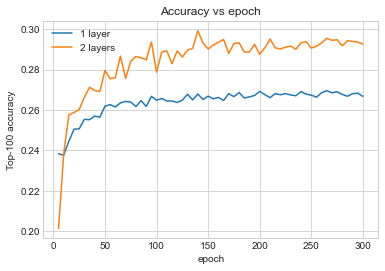

In [58]:
num_validation_runs=len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1) * 5 for x in range(num_validation_runs)]
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

In [59]:
model = MovielensModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
three_layer_history = model.fit(cached_train, validation_data=cached_test, validation_freq=5, epochs=num_epochs, verbose=0)
accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}")

Top-100 accuracy: 0.26


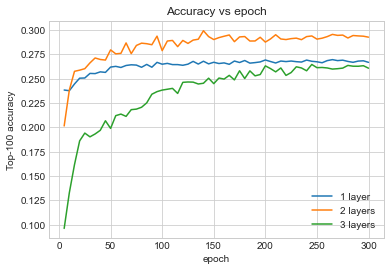

In [60]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

# Multi-task recommenders

In [1]:
import os 
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [2]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")
ratings = ratings.map(lambda x: {"movie_title":x["movie_title"], "user_id":x["user_id"], "user_rating": x["user_rating"]})
movies = movies.map(lambda x: x["movie_title"])

In [3]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [5]:
embedding_dimension=32
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])
movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

In [6]:
tfrs.tasks.Ranking(loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [7]:
tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(candidates=movies.batch(128)))

In [10]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, rating_weight: float, retrieval_weight:float)->None:
        super().__init__()
        embedding_dimension = 32
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanSquaredError(), 
                                                                     metrics= [tf.keras.metrics.RootMeanSquaredError()])
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(self.movie_model)))
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return (user_embeddings, movie_embeddings, 
                self.rating_model(tf.concat([user_embeddings, movie_embeddings], axis=1)))
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False)->tf.Tensor:
        ratings = features.pop("user_rating")
        user_embeddings, movie_embeddings, rating_predictions = self(features)
        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)
        return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)

In [11]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [12]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [15]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)
print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

Epoch 1/3
10/10 [==============================] - 11s 922ms/step - root_mean_squared_error: 2.0903 - factorized_top_k/top_1_categorical_accuracy: 3.7500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0297 - factorized_top_k/top_100_categorical_accuracy: 0.0590 - loss: 4.0315 - regularization_loss: 0.0000e+00 - total_loss: 4.0315
Epoch 2/3
10/10 [==============================] - 9s 948ms/step - root_mean_squared_error: 1.1531 - factorized_top_k/top_1_categorical_accuracy: 3.6250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0298 - factorized_top_k/top_100_categorical_accuracy: 0.0591 - loss: 1.3189 - regularization_loss: 0.0000e+00 - total_loss: 1.3189
Epoch 3/3
5/5 [==============================] - 2s 302ms/step - root_mean_squared_error: 1.1130 - factor

In [16]:
model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [17]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)
print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

Epoch 1/3
10/10 [==============================] - 18s 2s/step - root_mean_squared_error: 3.7237 - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0109 - factorized_top_k/top_10_categorical_accuracy: 0.0226 - factorized_top_k/top_50_categorical_accuracy: 0.1042 - factorized_top_k/top_100_categorical_accuracy: 0.1830 - loss: 69818.0312 - regularization_loss: 0.0000e+00 - total_loss: 69818.0312
Epoch 2/3
10/10 [==============================] - 16s 2s/step - root_mean_squared_error: 3.7495 - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0192 - factorized_top_k/top_10_categorical_accuracy: 0.0387 - factorized_top_k/top_50_categorical_accuracy: 0.1698 - factorized_top_k/top_100_categorical_accuracy: 0.2936 - loss: 67473.2898 - regularization_loss: 0.0000e+00 - total_loss: 67473.2898
Epoch 3/3
5/5 [==============================] - 4s 612ms/step - root_mean_squared_error: 3.7730 - fac

In [18]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [20]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)
print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

Epoch 1/3
10/10 [==============================] - 16s 2s/step - root_mean_squared_error: 1.1050 - factorized_top_k/top_1_categorical_accuracy: 0.0038 - factorized_top_k/top_5_categorical_accuracy: 0.0253 - factorized_top_k/top_10_categorical_accuracy: 0.0504 - factorized_top_k/top_50_categorical_accuracy: 0.2016 - factorized_top_k/top_100_categorical_accuracy: 0.3340 - loss: 65602.0036 - regularization_loss: 0.0000e+00 - total_loss: 65602.0036
Epoch 2/3
10/10 [==============================] - 16s 2s/step - root_mean_squared_error: 1.0810 - factorized_top_k/top_1_categorical_accuracy: 0.0040 - factorized_top_k/top_5_categorical_accuracy: 0.0280 - factorized_top_k/top_10_categorical_accuracy: 0.0545 - factorized_top_k/top_50_categorical_accuracy: 0.2135 - factorized_top_k/top_100_categorical_accuracy: 0.3489 - loss: 65097.8658 - regularization_loss: 0.0000e+00 - total_loss: 65097.8658
Epoch 3/3
5/5 [==============================] - 3s 663ms/step - root_mean_squared_error: 1.0773 - fac

In [21]:
trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
    "user_id": np.array(["42"]),
    "movie_title":np.array(["Dances with Wolves (1990)"])
})
print("Predicted rating", predicted_rating)
print("trained movie embedding", trained_movie_embeddings)
print("trained user embedding", trained_user_embeddings)

Predicted rating tf.Tensor([[3.5793304]], shape=(1, 1), dtype=float32)
trained movie embedding tf.Tensor(
[[-0.47201496 -0.21696286 -0.19615114  0.28087997 -0.31936994  0.1020024
  -0.5252435  -0.0618199  -0.10530175  0.0401685  -0.28725213 -0.16306148
   0.0197467  -0.31705463  0.35052034 -0.41117188 -0.07352148  0.49684745
   0.13696663 -0.8840319   0.12231104 -0.68635464 -0.23679088  0.25812957
   0.20754966 -0.4137165  -0.2680751   0.42008227  0.63815767  0.39554536
   0.02623803  0.09328106]], shape=(1, 32), dtype=float32)
trained user embedding tf.Tensor(
[[-0.21329698  0.21551362  0.16547231  0.51884377 -0.42537597 -0.4019745
  -0.23804833  0.6057597   0.4885018   0.02970351 -0.09316482  0.35688442
   0.00076877 -0.03081147 -0.07052242 -0.53007424  0.1321603   0.1921241
  -0.1529088  -0.42524317  0.09037887 -0.6652865   0.4500043  -0.45568243
  -0.21079607 -0.2427219   0.2144665   0.32247633  0.17279986 -0.3825349
  -0.01343493  0.49398783]], shape=(1, 32), dtype=float32)


# Deep and Cross Network (DCN)

In [1]:
import pprint
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [6]:
def get_mixer_data(data_size=100_000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    country = rng.randint(200, size=[data_size, 1]) / 200
    bananas = rng.randint(24, size=[data_size, 1]) / 24
    coockbooks = rng.randint(6, size=[data_size, 1]) / 6
    x = np.concatenate([country, bananas, coockbooks], axis=1)
    y = 0.1 * country + 0.4 * bananas + 0.7 * coockbooks
    y += 0.1 * country * bananas + 3.1 * bananas * coockbooks + 0.1 * coockbooks * coockbooks
    return x, y

In [7]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

In [10]:
class Model(tfrs.Model):
    def __init__(self, model):
        super().__init__()
        self._model = model
        self._logit_layer = tf.keras.layers.Dense(1)
        self.task = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanSquaredError(), 
                                       metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")])
    def call(self, x):
        x = self._model(x)
        return self._logit_layer(x)
    def compute_loss(self, features, training=False):
        x, labels = features
        scores = self(x)
        return self.task(labels=labels, predictions=scores)

In [12]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu")
]))

In [14]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

In [15]:
epochs = 100
learning_rate = 0.4

In [16]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [17]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

In [18]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} using {crossnet.count_params()} parameters")
deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} using {deepnet.count_params()} parameters")

CrossNet(1 layer) RMSE is 0.0007 using 16 parameters
DeepNet(large) RMSE is 0.1271 using 166401 parameters


<ipython-input-22-f1d849116c14>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
<ipython-input-22-f1d849116c14>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([''] + features, fontsize=10)


<Figure size 648x648 with 0 Axes>

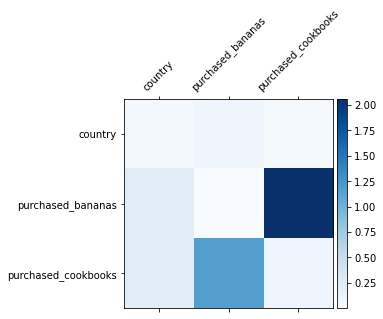

In [22]:
mat = crossnet._model._dense.kernel
features = ['country', "purchased_bananas", "purchased_cookbooks"]
plt.figure(figsize=(9, 9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10)
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

In [23]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id":x["movie_id"],
    "user_id":x["user_id"],
    "user_rating":x["user_rating"],
    "user_gender":int(x["user_gender"]),
    "user_zip_code":x["user_zip_code"],
    "user_occupation_text":x["user_occupation_text"],
    "bucketized_user_age":int(x["bucketized_user_age"])
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling movie_lens-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movie_lens downloaded and prepared to C:\Users\jatin\tensorflow_datasets\movie_lens\100k-ratings\0.1.0. Subsequent calls will reuse this data.


In [24]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [27]:
features_names = ["movie_id", "user_id", "user_gender", "user_zip_code", "user_occupation_text", "bucketized_user_age"]
vocabularies = {}
for feature_name in features_names:
    vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [38]:
class DCN(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()
        self.embedding_dimension = 32
        str_features = ["movie_id", "user_id", "user_zip_code", "user_occupation_text"]
        int_features = ["user_gender", "bucketized_user_age"]
        self._all_features = str_features + int_features
        self._embedding = {}
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embedding[feature_name] = tf.keras.Sequential([
                tf.keras.layers.StringLookup(vocabulary=vocabulary, mask_token=None),
                tf.keras.layers.Embedding(len(vocabulary) + 1, self.embedding_dimension)
            ])
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name] 
            self._embedding[feature_name] = tf.keras.Sequential([
                tf.keras.layers.IntegerLookup(vocabulary=vocabulary, mask_value=None),
                tf.keras.layers.Embedding(len(vocabulary) + 1, self.embedding_dimension)
            ])
        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(projection_dim=projection_dim, kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None
        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu") for layer_size in deep_layer_sizes]
        self._logit_layer = tf.keras.layers.Dense(1)
        self.task = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanSquaredError(), 
                                       metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")])
    def call(self, features):
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embedding[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))
        x = tf.concat(embeddings, axis=1)
        if self._cross_layer is not None:
            x = self._cross_layer(x)
        for deep_layer in self._deep_layers:
            x = deep_layer(x)
        return self._logit_layer(x)
    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")
        scores = self(features)
        return self.task(labels=labels, predictions=scores)

In [39]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [40]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
    models = []
    rmses = []
    for i in range(num_runs):
        model = DCN(use_cross_layer=use_cross_layer, deep_layer_sizes=deep_layer_sizes, projection_dim=projection_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)
        model.fit(cached_train, epochs=epochs, verbose=False)
        metrics = model.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])
    mean, stdv = np.average(rmses), np.std(rmses)
    return {"model":models, "mean":mean, "stdv":stdv}

In [41]:
epochs = 8
learning_rate = 0.01

In [42]:
dcn_result = run_models(use_cross_layer=True, deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 17ms/step - RMSE: 0.9296 - loss: 0.8637 - regularization_loss: 0.0000e+00 - total_loss: 0.8637


In [43]:
dcn_lr_result = run_models(use_cross_layer=True, projection_dim=20, deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 18ms/step - RMSE: 0.9376 - loss: 0.8797 - regularization_loss: 0.0000e+00 - total_loss: 0.8797


In [44]:
dnn_result = run_models(use_cross_layer=False, deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 16ms/step - RMSE: 0.9386 - loss: 0.8816 - regularization_loss: 0.0000e+00 - total_loss: 0.8816


In [45]:
print("DCN            RMSE mean: {:.4f}, stdv:{:.4f}".format(dcn_result['mean'], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv:{:.4f}".format(dcn_lr_result["mean"], dnn_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv:{:.4f}".format(dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.9304, stdv:0.0026
DCN (low-rank) RMSE mean: 0.9345, stdv:0.0043
DNN            RMSE mean: 0.9386, stdv:0.0043


<ipython-input-48-20d5d469f9f1>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
<ipython-input-48-20d5d469f9f1>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)


<Figure size 648x648 with 0 Axes>

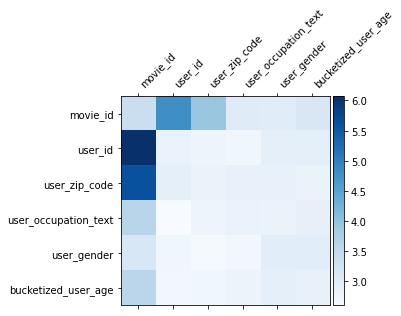

In [48]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features
block_norm = np.ones([len(features), len(features)])
dim = model.embedding_dimension
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim, j * dim:(j + 1) * dim]
        block_norm[i, j] = np.linalg.norm(block, ord="fro")
plt.figure(figsize=(9, 9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10)
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

# Listwise ranking

In [49]:
import pprint
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

In [50]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")
ratings = ratings.map(lambda x: {"movie_title":x["movie_title"], "user_id":x["user_id"], "user_rating":x["user_rating"]})
movies = movies.map(lambda x: x["movie_title"])
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"]))))

In [51]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)
train = tfrs.examples.movielens.sample_listwise(train, num_list_per_user=50, num_examples_per_list=5, seed=42)
test = tfrs.examples.movielens.sample_listwise(test, num_list_per_user=1, num_examples_per_list=5, seed=42)

In [52]:
for example in train.take(1):
    pprint.pprint(example)

{'movie_title': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Postman, The (1997)', b'Liar Liar (1997)', b'Contact (1997)',
       b'Welcome To Sarajevo (1997)',
       b'I Know What You Did Last Summer (1997)'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'681'>,
 'user_rating': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([4., 5., 1., 4., 1.], dtype=float32)>}


In [68]:
class RankingModel(tfrs.Model):
    def __init__(self, loss):
        super().__init__()
        embedding_dimension = 32
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids),
            tf.keras.layers.Embedding(len(unique_user_ids) + 2, embedding_dimension)
        ])
        self.movie_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 2, embedding_dimension)
        ])
        self.score_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
        self.task = tfrs.tasks.Ranking(loss=loss, metrics=[tfr.keras.metrics.NDCGMetric(name="ndcg_metric"), 
                                                          tf.keras.metrics.RootMeanSquaredError()])
    def call(self, features):
        user_embeddings = self.user_embedding(features["user_id"])
        movie_embeddings = self.movie_embedding(features["movie_title"])
        list_length = features["movie_title"].shape[1]
        user_embedding_repeated = tf.repeat(tf.expand_dims(user_embeddings, 1), [list_length], axis=1)
        concatenated_embeddings = tf.concat([user_embedding_repeated, movie_embeddings], 2)
        return self.score_model(concatenated_embeddings)
    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")
        scores = self(features)
        return self.task(labels=labels, predictions=tf.squeeze(scores, axis=-1))

In [69]:
epochs = 30
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [70]:
mse_model = RankingModel(tf.keras.losses.MeanSquaredError())
mse_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [71]:
mse_model.fit(cached_train, epochs=epochs, verbose=False)

In [72]:
hinge_model = RankingModel(tfr.keras.losses.PairwiseHingeLoss())
hinge_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
hinge_model.fit(cached_train, epochs=epochs, verbose=False)

In [73]:
listwise_model = RankingModel(tfr.keras.losses.ListMLELoss())
listwise_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [74]:
listwise_model.fit(cached_train, epochs=epochs, verbose=False)

In [75]:
mse_model_result = mse_model.evaluate(cached_test, return_dict=True)
print("NDCG of the MSE Model: {:.4f}".format(mse_model_result["ndcg_metric"]))

1/1 [==============================] - 1s 696ms/step - ndcg_metric: 0.9054 - root_mean_squared_error: 0.9638 - loss: 0.9289 - regularization_loss: 0.0000e+00 - total_loss: 0.9289
NDCG of the MSE Model: 0.9054


In [76]:
hinge_model_result = hinge_model.evaluate(cached_test, return_dict=True)
print("NDCG of the pairwise hinge loss model: {:.4f}".format(hinge_model_result["ndcg_metric"]))

1/1 [==============================] - 1s 987ms/step - ndcg_metric: 0.9061 - root_mean_squared_error: 3.5741 - loss: 1.0226 - regularization_loss: 0.0000e+00 - total_loss: 1.0226
NDCG of the pairwise hinge loss model: 0.9061


In [77]:
listwise_model_result = listwise_model.evaluate(cached_test, return_dict=True)
print("NDCG of the ListMLE model: {:.4f}".format(listwise_model_result["ndcg_metric"]))

1/1 [==============================] - 1s 937ms/step - ndcg_metric: 0.9063 - root_mean_squared_error: 3.3248 - loss: 4.5379 - regularization_loss: 0.0000e+00 - total_loss: 4.5379
NDCG of the ListMLE model: 0.9063


# Deep Dream

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

In [29]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

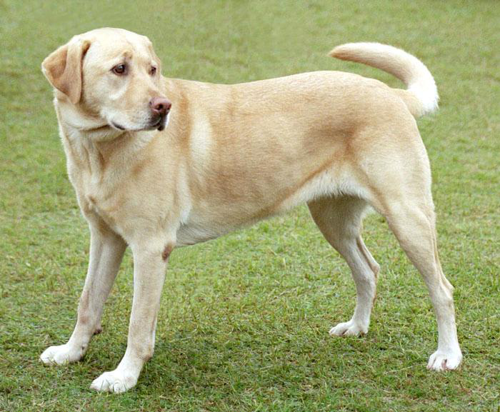

In [30]:
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))
    
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [31]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 181s 2us/step


In [33]:
names = ["mixed3", "mixed5"]
layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [39]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [40]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32), 
                                  tf.TensorSpec(shape=[], dtype=tf.int32), 
                                 tf.TensorSpec(shape=[], dtype=tf.float32)))
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            gradients = tape.gradient(loss, img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
        return loss, img

In [41]:
deepdream = DeepDream(dream_model)

In [42]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        display.clear_output(wait=True)
        show(deprocess(img))
        print("Step {}, loss {}".format(step, loss))
    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)
    return result

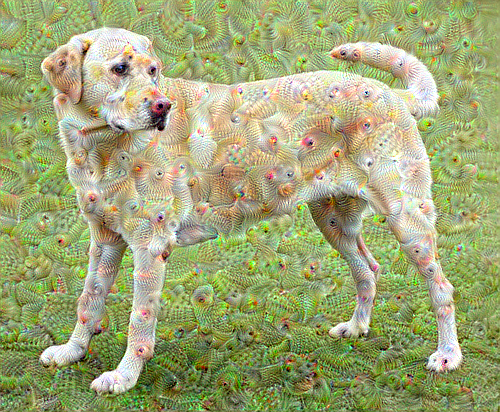

In [43]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

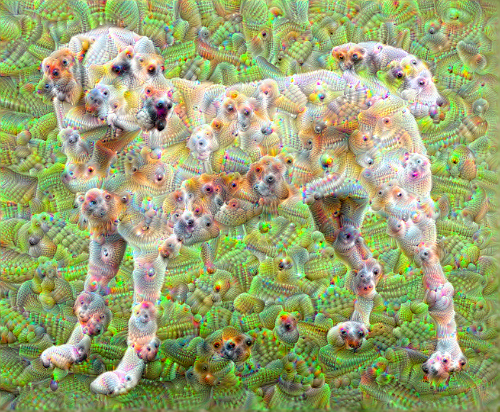

303.07025957107544

In [45]:
import time 
start = time.time()
OCTAVE_SCALE = 1.30
img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)
for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)
end = time.time()
end-start

In [46]:
def random_roll(img, maxroll):
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0, 1])
    return shift, img_rolled

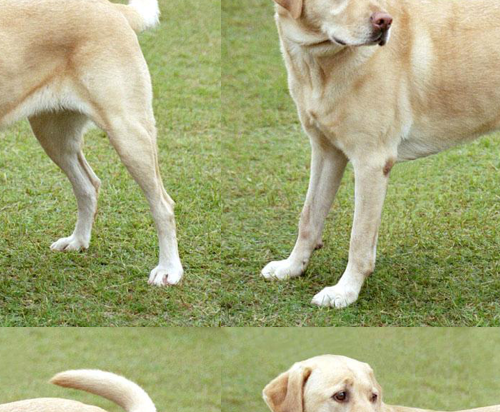

In [47]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [48]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32), 
                                 tf.TensorSpec(shape=[], dtype=tf.int32)))
    def __call__(self, img, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)
        gradients = tf.zeros_like(img_rolled)
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])
        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)
                    img_tile = img_rolled[x:x+tile_size, y:y + tile_size]
                    loss = calc_loss(img_tile, self.model)
                gradients = gradients + tape.gradient(loss, img_rolled)
        gradients = tf.roll(gradients, shift=-shift, axis=[0, 1])
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        return gradients

In [49]:
get_tiled_gradients = TiledGradients(dream_model)

In [53]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, octaves=range(-2, 3), octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.utils.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32) * (octave_scale ** octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))
        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print("Octave {}, step {}".format(octave, step))
    result = deprocess(img)
    return result

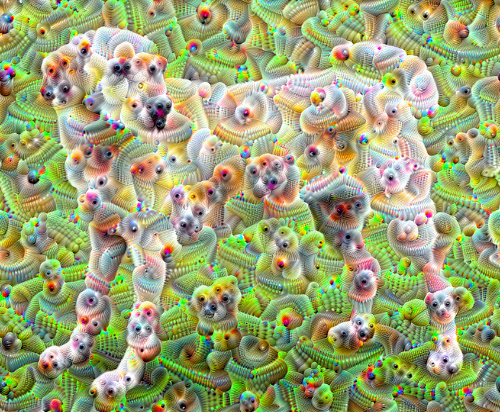

In [55]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

# Deep Convolutional Generative Adversarial Network

In [56]:
import tensorflow as tf

In [57]:
tf.__version__

'2.7.0'

In [58]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [60]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [61]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [62]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/127.5

In [63]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [65]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)
    return model

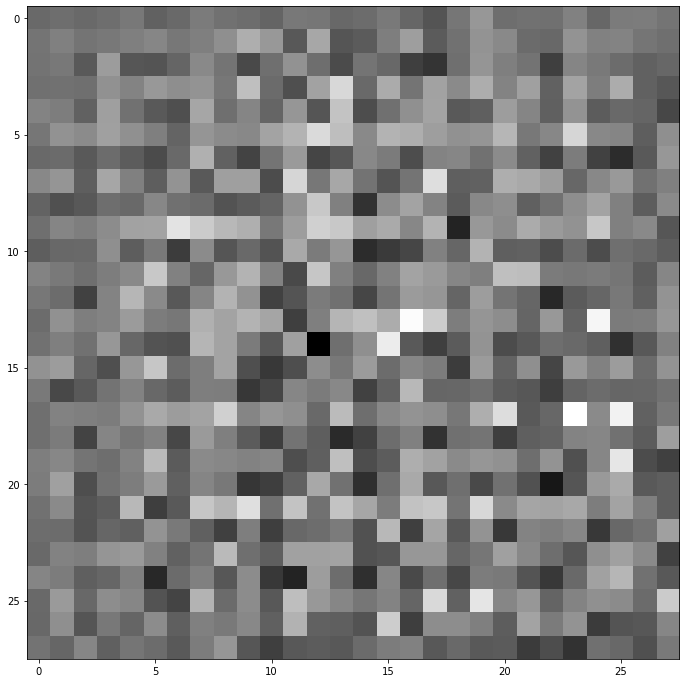

In [66]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [67]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [68]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00141513]], shape=(1, 1), dtype=float32)


In [79]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [80]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [81]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [82]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [83]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [84]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [85]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [89]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [90]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

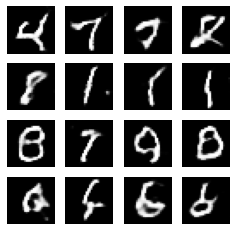

In [91]:
train(train_dataset, EPOCHS)

In [92]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [93]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

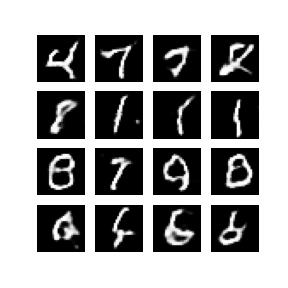

In [95]:
display_image(EPOCHS)

In [96]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [97]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'

In [99]:
pip install tensorflow_docs

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow_docs
ERROR: No matching distribution found for tensorflow_docs


# pix2pix: image-to-image translation with a conditional GAN

In [1]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

In [2]:
dataset_name = "facades"

In [3]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'
path_to_zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz", origin=_URL, extract=True)
path_to_zip = pathlib.Path(path_to_zip)
PATH = path_to_zip.parent/dataset_name

In [4]:
list(PATH.parent.iterdir())

[WindowsPath('C:/Users/jatin/.keras/datasets/194px-New_East_River_Bridge_from_Brooklun_det.4a097u.jpg'),
 WindowsPath('C:/Users/jatin/.keras/datasets/320px-Felis_catus-cat_on_snow.jpg'),
 WindowsPath('C:/Users/jatin/.keras/datasets/butler.txt'),
 WindowsPath('C:/Users/jatin/.keras/datasets/cats_and_dogs.zip'),
 WindowsPath('C:/Users/jatin/.keras/datasets/cats_and_dogs_filtered'),
 WindowsPath('C:/Users/jatin/.keras/datasets/cifar-10-batches-py'),
 WindowsPath('C:/Users/jatin/.keras/datasets/cifar-10-batches-py.tar.gz'),
 WindowsPath('C:/Users/jatin/.keras/datasets/cowper.txt'),
 WindowsPath('C:/Users/jatin/.keras/datasets/derby.txt'),
 WindowsPath('C:/Users/jatin/.keras/datasets/facades'),
 WindowsPath('C:/Users/jatin/.keras/datasets/facades.tar.gz'),
 WindowsPath('C:/Users/jatin/.keras/datasets/fashion-mnist'),
 WindowsPath('C:/Users/jatin/.keras/datasets/flower_photos'),
 WindowsPath('C:/Users/jatin/.keras/datasets/flower_photos.tar.gz'),
 WindowsPath('C:/Users/jatin/.keras/datasets/

In [5]:
sample_image = tf.io.read_file(str(PATH/'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


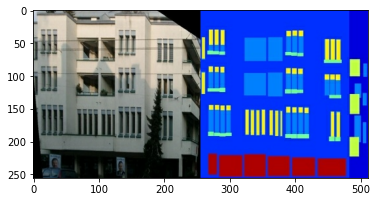

In [6]:
plt.figure()
plt.imshow(sample_image)

In [7]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w//2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

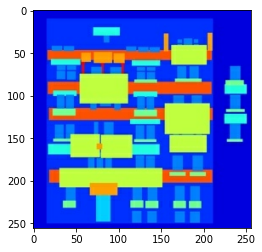

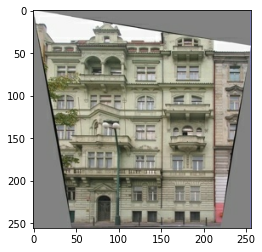

In [8]:
inp, re = load(str(PATH / 'train/100.jpg'))
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [9]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [11]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

In [12]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [13]:
@tf.function
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

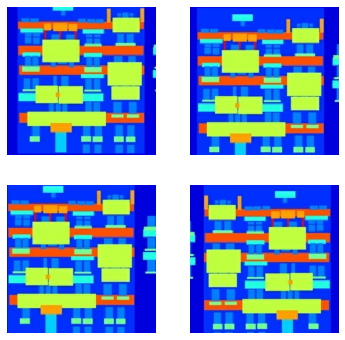

In [14]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [15]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [16]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [17]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [18]:
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH/'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Datase.list_files(str(PATH/'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [19]:
OUTPUT_CHANNELS = 3

In [20]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding="same", kernel_initializer=initializer, 
                                      use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [22]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, 
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [23]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [24]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding="same", kernel_initializer=initializer, 
                                           activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
generator = Generator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


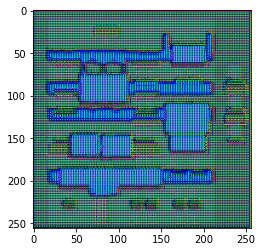

In [26]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [27]:
LAMBDA = 100

In [28]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [30]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [31]:
discriminator = Discriminator()

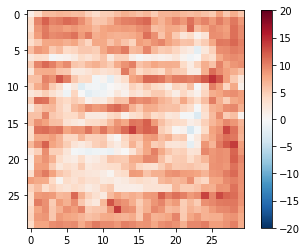

In [32]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [33]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [35]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [36]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

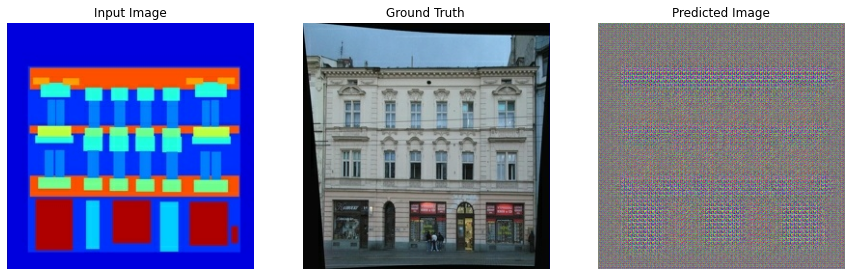

In [37]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [38]:
log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [39]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_g1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [40]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if step % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time() - start:.2f} sec\n')
            start = time.time()
            generate_images(generator, example_input, example_target)
            print(f'Step: {step//1000}k')
        train_step(input_image, target, step)
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 1270.21 sec



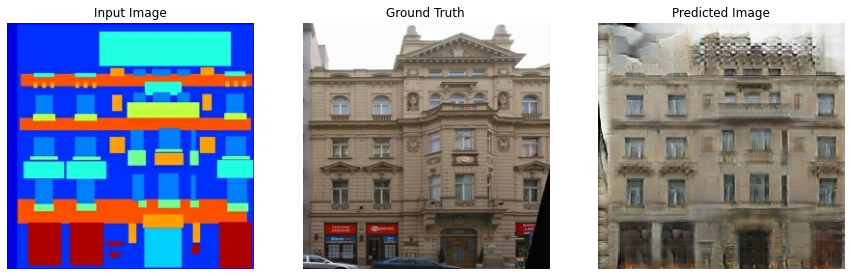

Step: 39k
....................................................................................................

In [41]:
fit(train_dataset, test_dataset, steps=40000)

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

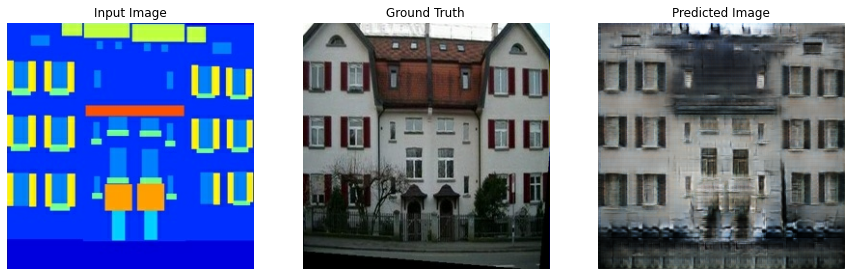

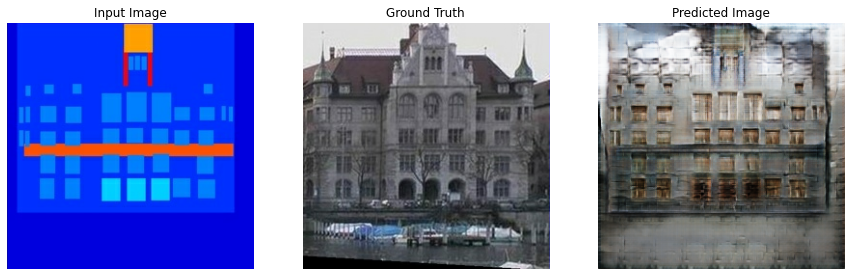

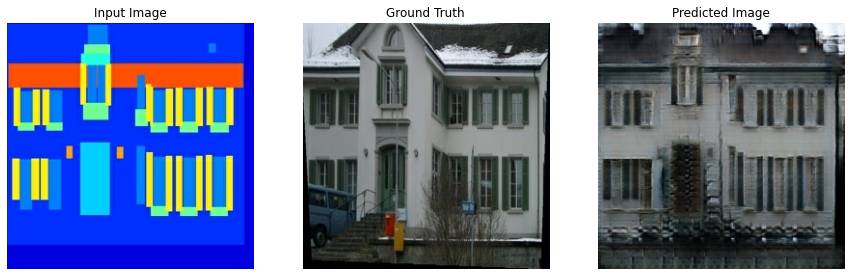

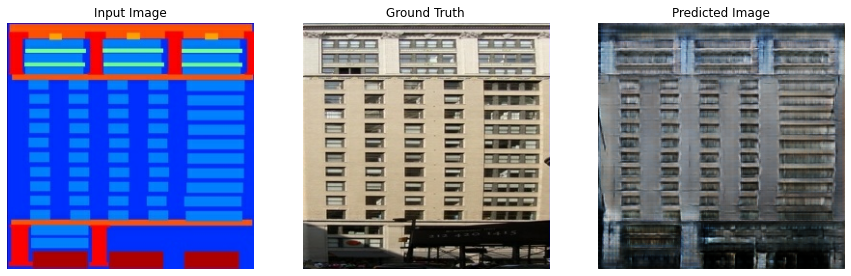

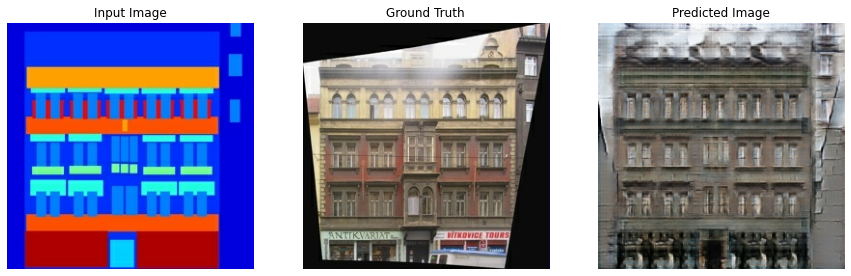

In [43]:
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)